In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

In [191]:
# 전체 출력 설정
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력

# 데이터 읽어오기

In [192]:
# 기존 데이터
df_2021 = pd.read_csv('data/konex_suv_2021.csv')
df_2022 = pd.read_csv('data/konex_suv_2022.csv')
df_2023 = pd.read_csv('data/konex_suv_2023.csv')
df = pd.read_csv('data/konex_final_with_cat.csv')
print(df_2021.shape, df_2022.shape, df_2023.shape, df.shape)

# 완성본 데이터
df_2021_capital = pd.read_csv('data/final_자본시장_2021_50.csv')
df_2022_capital = pd.read_csv('data/final_자본시장_2022_50.csv')
df_2023_capital = pd.read_csv('data/final_자본시장_2023_50.csv')
df_2021_index = pd.read_csv('data/final_파생지표_2021_50.csv')
df_2022_index = pd.read_csv('data/final_파생지표_2022_50.csv')
df_2023_index = pd.read_csv('data/final_파생지표_2023_50.csv')
print(df_2021_capital.shape, df_2021_index.shape)


(189, 87) (189, 87) (189, 87) (189, 326)
(175, 8) (175, 14)


In [193]:
df_2023_index.head(2)

,유지기간,suv,EPS,BPS,PER,PBR,ROA,ROE,X1,X2,X3,X4,X5,q
0,825 days,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2659 days,True,0.759478,11.385849,20641.037224,1376.832612,0.066704,0.126811,548524.660646,0.121656,0.009661,4281.600496,0.535958,5.909092e+10


### 데이터 핸들링 및 처리

In [194]:
# 생존 여부 칼럼 추가 -> 0이면 생존, 1이면 사망(폐지)
def data_handling(df):
    df['유지기간'] = df['유지기간'].str.replace(' days', '').astype(int)
    df['상장일'] = pd.to_datetime(df['상장일'])
    df['코넥스폐지일자'] = pd.to_datetime(df['코넥스폐지일자'])
    df['suv'] = np.where(df['코넥스폐지일자'].isnull(), 0, 1)
    df.drop(columns=['코넥스비고'], inplace = True)

    # 특성 이름에서 허용되지 않는 문자 제거
    df.columns = df.columns.str.replace(r'[\[\]{}()."]', '_', regex=True)
    return df

def data_handling_2(df):
    df['상장일'] = pd.to_datetime(df['상장일'])
    df['코넥스폐지일자'] = pd.to_datetime(df['코넥스폐지일자'])
    df['suv'] = np.where(df['코넥스폐지일자'].isnull(), 0, 1)
    df.drop(columns=['코넥스폐지사유'], inplace = True)
    df.drop(columns=['코넥스비고'], inplace = True)

    # 특성 이름에서 허용되지 않는 문자 제거
    df.columns = df.columns.str.replace(r'[\[\]{}()."]', '_', regex=True)
    return df

df = data_handling(df)
df_2021 = data_handling_2(df_2021)
df_2022 = data_handling_2(df_2022)
df_2023 = data_handling_2(df_2023)


In [195]:
# 최종 데이터 기반 핸들링

def fix_data(df):
    df['유지기간'] = df['유지기간'].str.replace(' days', '').astype(int)
    df = df.fillna(0)
    return df

df_2021_capital = fix_data(df_2021_capital)
df_2022_capital = fix_data(df_2022_capital)
df_2023_capital = fix_data(df_2023_capital)

df_2021_index = fix_data(df_2021_index)
df_2022_index = fix_data(df_2022_index)
df_2023_index = fix_data(df_2023_index)

In [196]:
# 모든 변수가 0인 샘플 제거하기 -> Cox분석에 의미 없음

df_2021_index_tmp = df_2021_index[(df_2021_index.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]
df_2022_index_tmp = df_2022_index[(df_2022_index.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]
df_2023_index_tmp = df_2021_index[(df_2023_index.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]

df_2021_capital_tmp = df_2021_capital[(df_2021_capital.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]
df_2022_capital_tmp = df_2021_capital[(df_2022_capital.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]
df_2023_capital_tmp = df_2021_capital[(df_2023_capital.drop(columns=['유지기간', 'suv']).ne(0).any(axis=1))]

In [197]:
def logpi_data(df):

    df_vari = df[['유지기간', 'suv']]
    df = df.drop(columns=['유지기간', 'suv'])  # drop 결과를 df에 반영

    # 로그 변환 (음수 및 0 방지)
    df = df.applymap(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)

    # 가로 방향으로 결합 (axis=1)
    df = pd.concat([df, df_vari], axis=1)
    df = df.fillna(0)

    return df

In [198]:
# 변수 로그화화

df_2021_index_log = logpi_data(df_2021_index_tmp)
df_2022_index_log = logpi_data(df_2022_index_tmp)
df_2023_index_log = logpi_data(df_2023_index_tmp)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\19295620.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\19295620.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\19295620.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)


# 변수 분포 확인

In [199]:

def remove_outliers_and_plot_histograms(df):
    # 이상치 제거
    for col in df.columns[2:]:  # 첫 두 열을 제외한 모든 열에 대해
        Q1 = df[col].quantile(0.25)  # 1사분위수
        Q3 = df[col].quantile(0.75)  # 3사분위수
        IQR = Q3 - Q1  # IQR 계산

        # 이상치 경계 설정
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    # 히스토그램 그리기
    columns_to_plot = df.columns[2:]  # 첫 두 열을 제외한 열 선택
    num_cols = 4
    num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols  # 필요한 행 수 계산
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()  # 2D 배열을 1D로 변환

    # 각 열에 대해 히스토그램 그리기
    for i, col in enumerate(columns_to_plot):
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('값')
        axes[i].set_ylabel('빈도')

    # 남은 서브플롯 비우기
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\2971896029.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\2971896029.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\2971896029.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

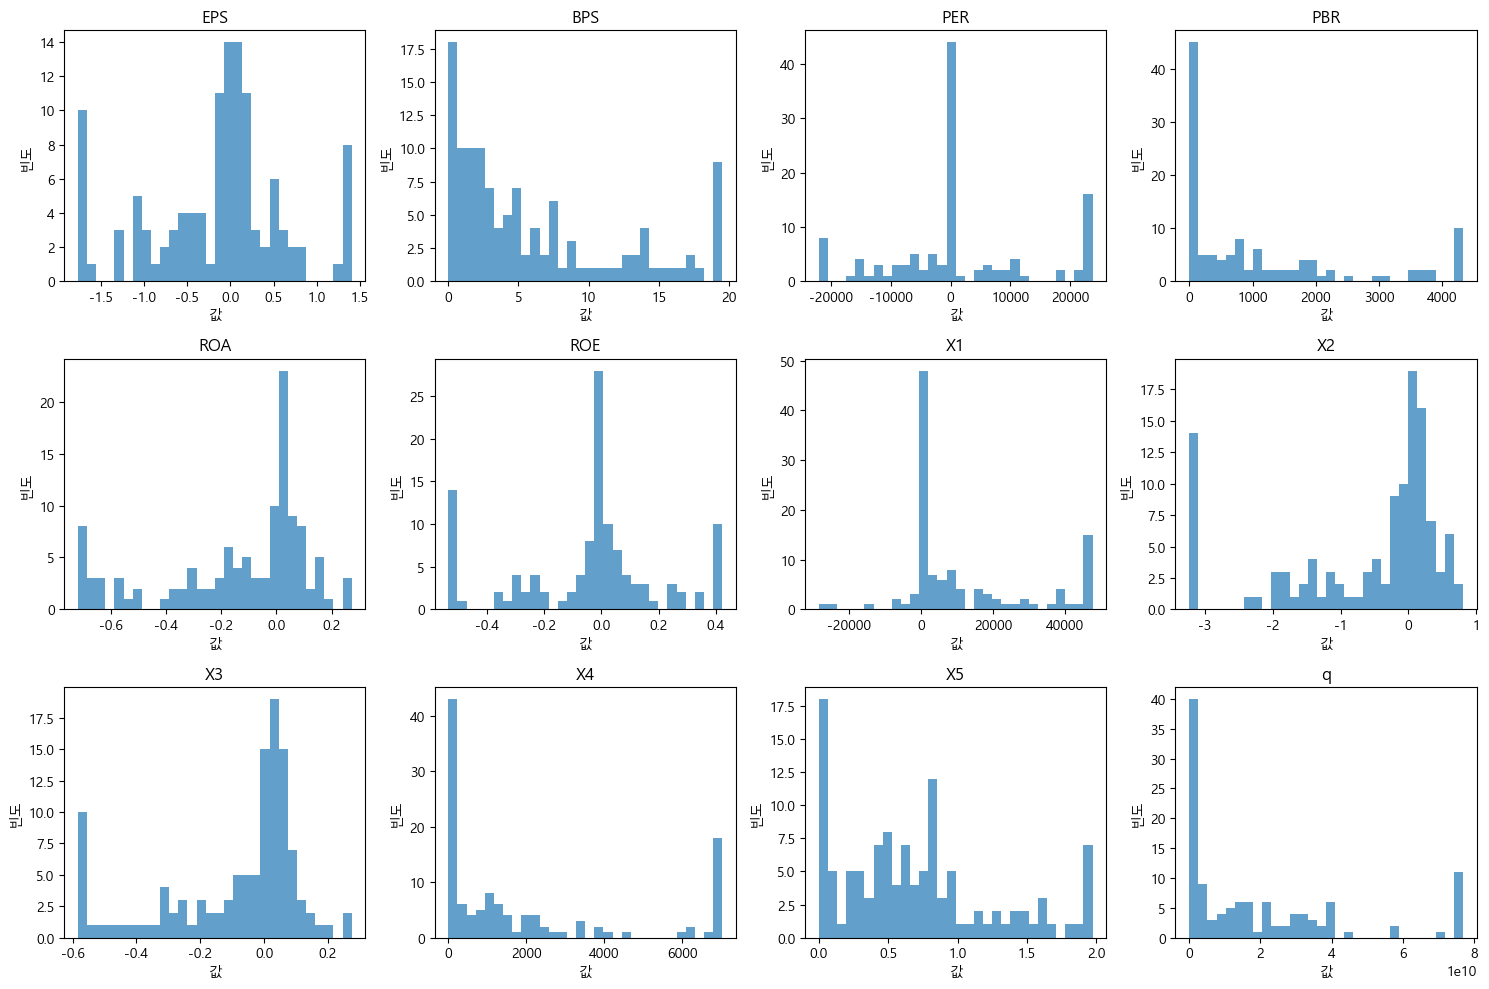

In [200]:
remove_outliers_and_plot_histograms(df_2023_index_tmp)

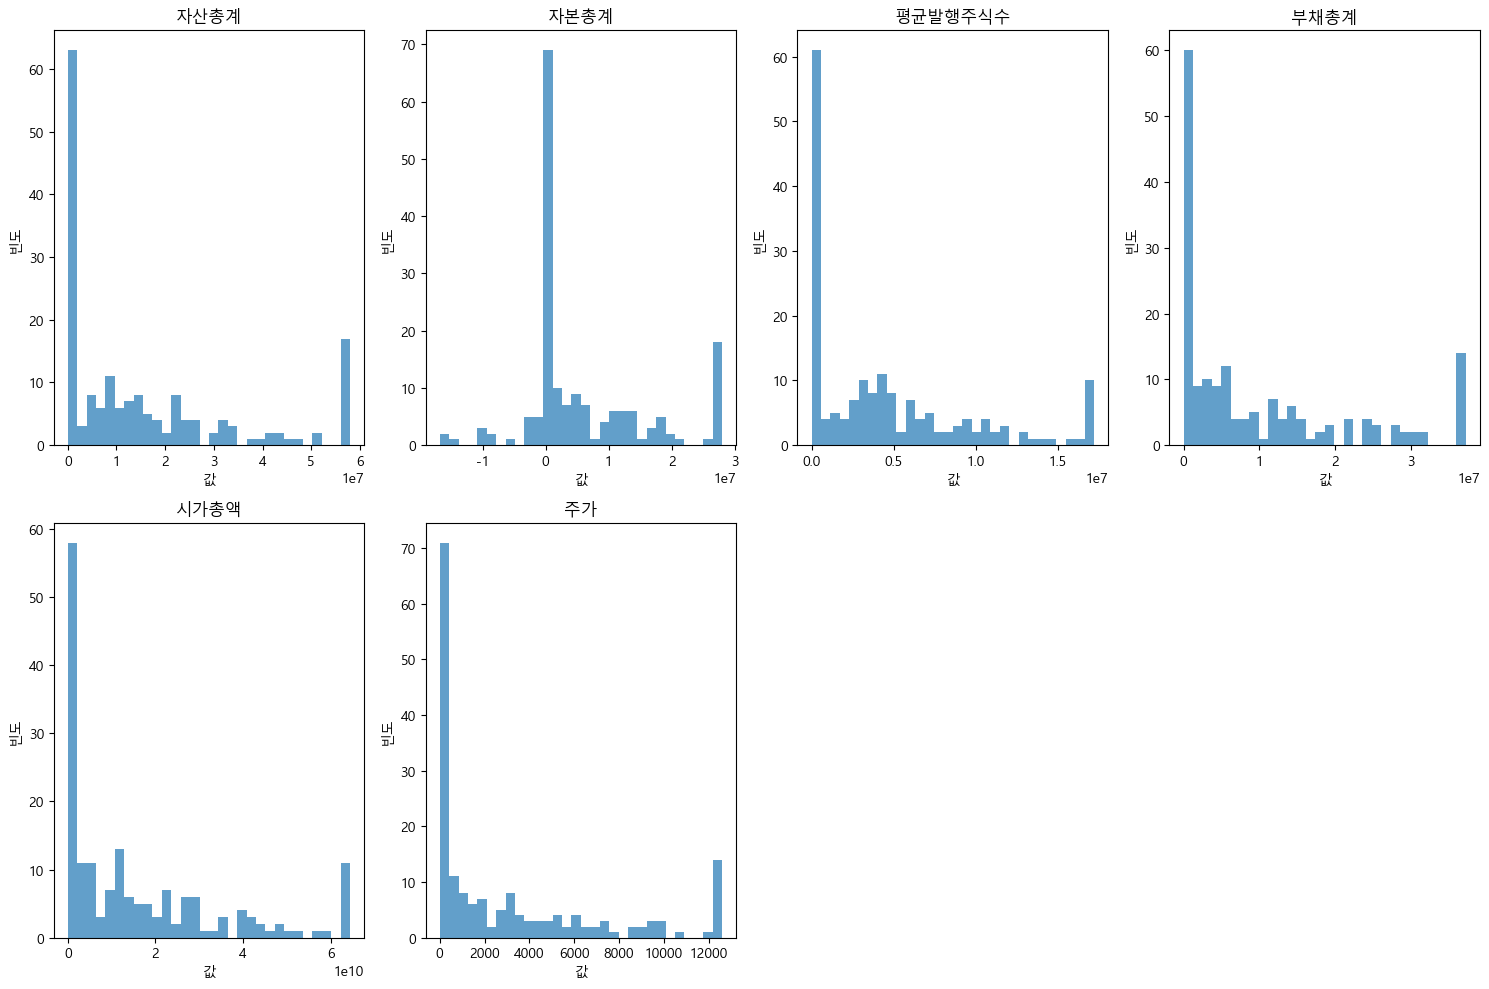

In [201]:
remove_outliers_and_plot_histograms(df_2023_capital)

# 다중공산성 확인 및 변수 처리 -> 연도별로

   Variable        VIF
0       EPS   1.457757
1       BPS   3.235117
2       PER   2.586869
3       PBR  27.601925
4       ROA   2.076966
5       ROE   1.034834
6        X1   3.203472
7        X2   1.130006
8        X3   2.322386
9        X4  69.938711
10       X5   3.449240
11        q  66.360139
12     유지기간   5.954524


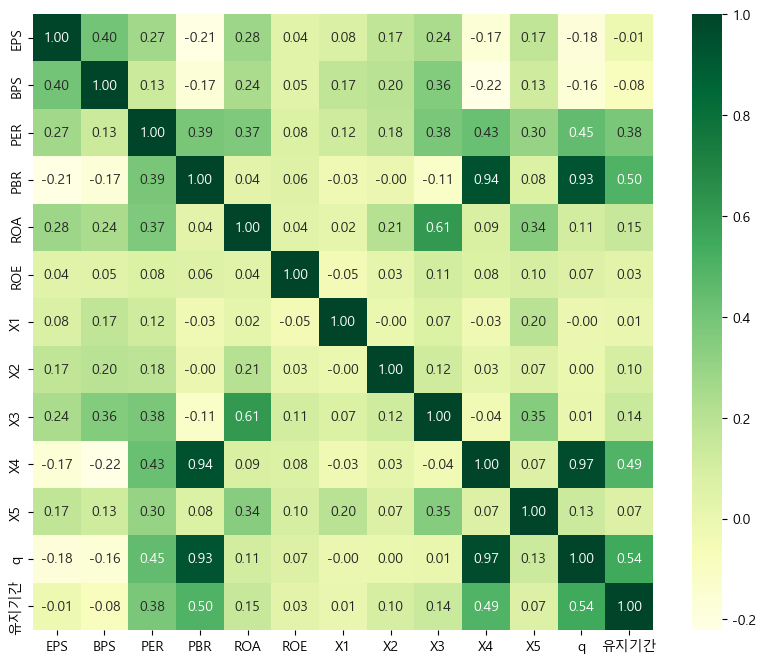

In [202]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 독립변수(연속형 변수)만 포함한 데이터프레임 선택
X = df_2021_index_log.select_dtypes(include=['number'])  # 숫자형 변수만 선택

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

   Variable        VIF
0       EPS   1.942363
1       BPS   4.053506
2       PER   2.119035
3       PBR  34.839803
4       ROA   1.888837
5       ROE   1.145646
6        X1   2.812135
7        X2   1.110966
8        X3   1.756157
9        X4  78.085203
10       X5   3.490832
11        q  68.144143
12     유지기간   5.502731


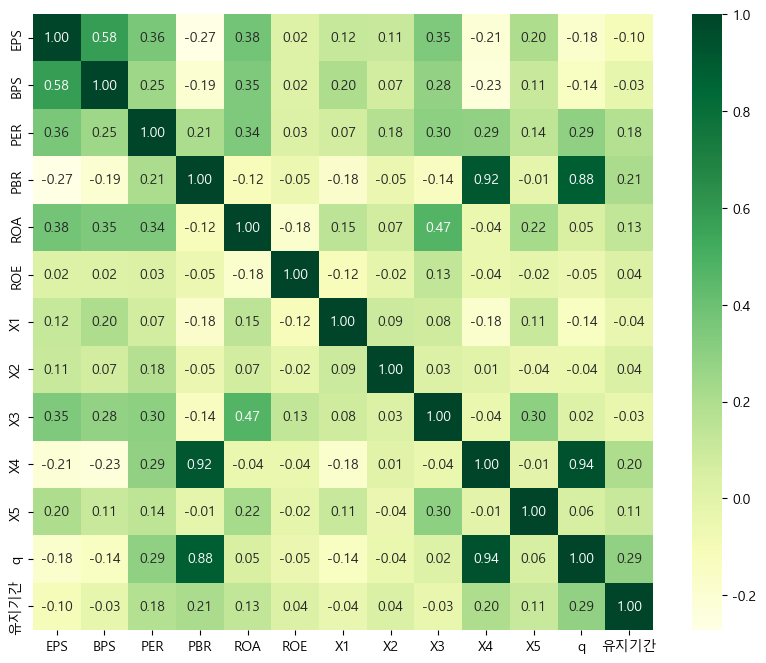

In [203]:
# 독립변수(연속형 변수)만 포함한 데이터프레임 선택
X = df_2022_index_log.select_dtypes(include=['number'])  # 숫자형 변수만 선택

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

# EPS, BPS 삭제제


   Variable        VIF
0       EPS   1.459242
1       BPS   3.234009
2       PER   2.631468
3       PBR  25.774168
4       ROA   2.071167
5       ROE   1.037148
6        X1   3.069859
7        X2   1.094808
8        X3   2.327482
9        X4  69.914817
10       X5   3.387281
11        q  65.856102
12     유지기간   6.177787


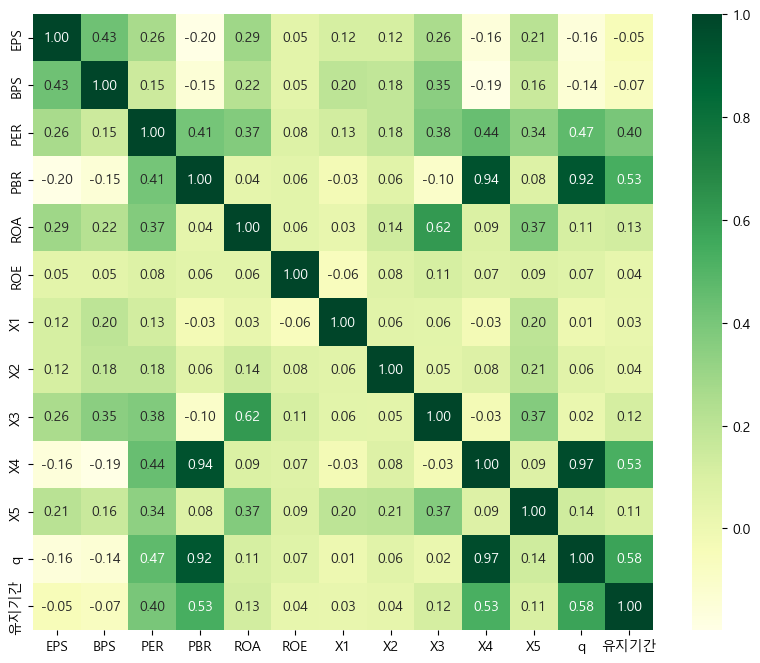

In [204]:
# 독립변수(연속형 변수)만 포함한 데이터프레임 선택
X = df_2023_index_log.select_dtypes(include=['number'])  # 숫자형 변수만 선택

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

# PBR, ROA 삭제제

In [205]:
# 2021, 2023년은 ROA 와 PBR를 제외하고 돌려보자.
# 2022년은 EPS, BPS 삭제

df_2021_cox = df_2021_index_log.drop(columns=['PBR', 'X4'])
df_2022_cox = df_2022_index_log.drop(columns=['PBR', 'X4'])
df_2023_cox = df_2023_index_log.drop(columns=['PBR', 'X4'])

   Variable       VIF
0       EPS  1.411816
1       BPS  3.122355
2       PER  2.607189
3       ROA  2.061682
4       ROE  1.035325
5        X1  3.024181
6        X2  1.079841
7        X3  2.114352
8        X5  3.372182
9         q  5.548247
10     유지기간  6.149703


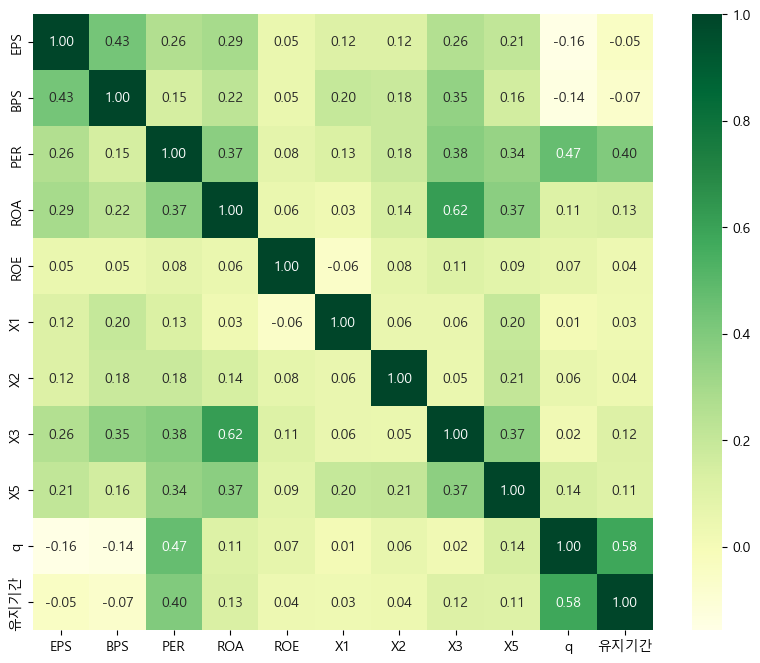

In [206]:
# 독립변수(연속형 변수)만 포함한 데이터프레임 선택
X = df_2023_cox.select_dtypes(include=['number'])  # 숫자형 변수만 선택

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

# PBR, ROA 삭제제

# 생존분석 적용

- 생존분석을 위해선 생존 여부, 설명변수, 시간이라는 데이터가 필요하다.
- 현재 시간, 설명변수는 충분히 확보되었고, 생존 여부를 조금 고칠 필요가 있어보임.

- 생존시간 -> 유지기간, int로 구현
- 생존여부 -> 코넥스폐지일자 가 NaN이면 2023년 기준 생존 -> suv 열로 구현
- 설명변수 -> 그 외의 것들.

## 카플란 - 마이어
- 이벤트가 발생하지 않을 확률을 기반으로 함

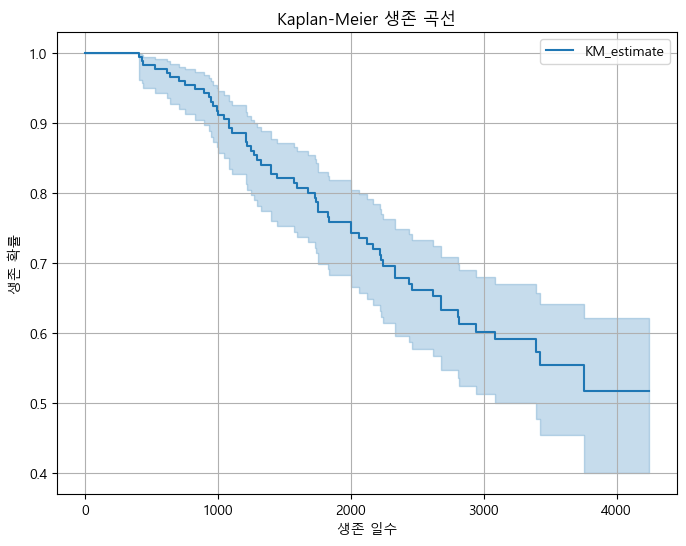

In [207]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier Fitter 모델 생성
kmf = KaplanMeierFitter()

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))
kmf.fit(durations=df['유지기간'], event_observed=df['suv'])
kmf.plot_survival_function()
plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

(60, 326) (129, 326)


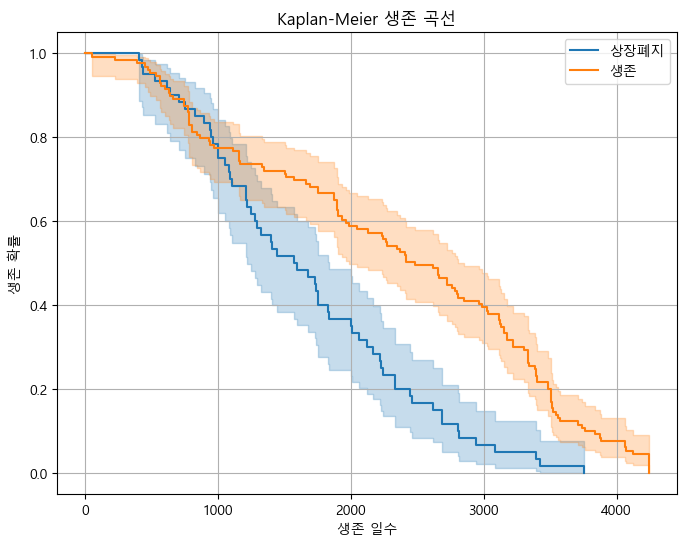

In [208]:
# 폐지된 그룹과 아닌 그룹의 케플란-마이어 결과
tmp_closed = df[df['suv']==1] # 코넥스에서 폐지당한 애들 -> train
tmp_suv =  df[df['suv']==0] # 코넥스에서 폐지 안 당한 애들 -> target

print(tmp_closed.shape, tmp_suv.shape)


# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))

kmf.fit(durations=tmp_closed['유지기간'], label = '상장폐지')
kmf.plot_survival_function()

kmf.fit(durations=tmp_suv['유지기간'], label = '생존')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

## Cox비례위험모델
- 카플란-마이어는 생존시간과 생존 여부만을 고려함. 따라서, 설명변수들을 고려하려면 Cox비례위험모델을 사용해야 한다.
- 시간에 따른 사건 발생률을 모델링.
- 공변량이 생존 시간에 미치는 영향을 평가하는데 유용함 -> 현재 칼럼이 너무 많음.
- 저변동성 칼럼 역시 모두 삭제되어야한다 (값의 대부분이 NaN인 칼럼들)

In [209]:
# Cox비례위험모델에는 숫자형, Bool형의 데이터만 가능 -> STR, Datetime모두 불가능하다.
# 또한, NaN 역시 존재하면 안 된다. 결측치는 우선적으로 0으로 처리한다.

def filter_numeric_columns(df):
    # 숫자형 칼럼만 필터링
    numeric_cols = df.select_dtypes(include=['number', 'bool']).columns
    df_done = df[numeric_cols]
    
    # NaN 값을 0으로 대체
    df_done.fillna(0, inplace=True)

    return df_done

# 데이터 적용
df_nums = filter_numeric_columns(df)

df_2021_index = filter_numeric_columns(df_2021_index)
df_2022_index = filter_numeric_columns(df_2022_index)
df_2023_index = filter_numeric_columns(df_2023_index)

df_2021_capital = filter_numeric_columns(df_2021_capital)
df_2022_capital = filter_numeric_columns(df_2022_capital)
df_2023_capital = filter_numeric_columns(df_2023_capital)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\581313856.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_done.fillna(0, inplace=True)


In [210]:
# 회계 지표만 남기기 -> df_nums에만 적용 가능

df_suv = df_nums[df_nums.columns[-25:].tolist() + df_nums.columns[:2].tolist()]
df_suv.drop(columns=[col for col in df_suv.columns if '2020' in col], inplace=True)  # '2020'년도 삭제

# 분석 시 의미 없었던 칼럼 삭제
df_suv.drop(columns=['종목코드', 'X4_2021', 'X4_2022', 'X4_2023', 'q_2021', 'q_2022', 'q_2023'], inplace=True)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\1684299726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suv.drop(columns=[col for col in df_suv.columns if '2020' in col], inplace=True)  # '2020'년도 삭제
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_38268\1684299726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suv.drop(columns=['종목코드', 'X4_2021', 'X4_2022', 'X4_2023', 'q_2021', 'q_2022', 'q_2023'], inplace=True)


<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -228.09
         time fit was run = 2025-02-24 08:19:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2021   -2.92      0.05      2.74           -8.29            2.46                0.00               11.66
X2_2021   -1.44      0.24      1.42           -4.23            1.34                0.01                3.84
X5_2021    1.22      3.39      1.56           -1.84            4.28                0.16               72.19
X1_2022   -5.09      0.01      3.40          -11.76            1.57                0.00                4.80
X2_2022    1.82      6.15      1.29           -0.72            4.35                0.49               77.75
X5_2022   -0.81      0.44      1.37           -3.49            1.86                0.03                6.45
X1_2023    2.21      9.12      3.58           -4.81            9.23                0.01            10177.02
X2_2023   -0.38      0.68      0.78           -1.91            1.14                0.15                3.13
X5_2023   -4.47      0.01      1.10           -6.63           -2.30                0.00                0.10
X3_2021    0.27      1.30      3.27           -6.15            6.68                0.00              796.66
X3_2022   -1.30      0.27      2.96           -7.11            4.50                0.00               89.78
X3_2023    7.02   1118.06      3.76           -0.36           14.40                0.70            1.79e+06

           cmp to     z      p  -log2(p)
covariate                               
X1_2021      0.00 -1.06   0.29      1.80
X2_2021      0.00 -1.01   0.31      1.69
X5_2021      0.00  0.78   0.43      1.21
X1_2022      0.00 -1.50   0.13      2.90
X2_2022      0.00  1.40   0.16      2.64
X5_2022      0.00 -0.59   0.55      0.86
X1_2023      0.00  0.62   0.54      0.90
X2_2023      0.00 -0.49   0.62      0.69
X5_2023      0.00 -4.05 <0.005     14.23
X3_2021      0.00  0.08   0.94      0.10
X3_2022      0.00 -0.44   0.66      0.60
X3_2023      0.00  1.86   0.06      4.01
---
Concordance = 0.87
Partial AIC = 480.18
log-likelihood ratio test = 104.19 on 12 df
-log2(p) of ll-ratio test = 53.40

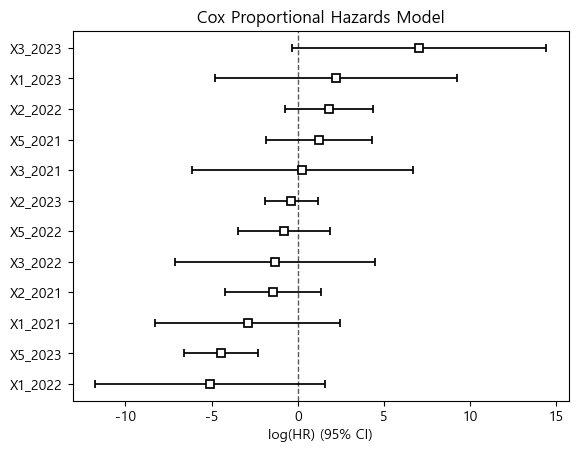

In [211]:
from lifelines import CoxPHFitter

# df_nums를 대상으로 분석을 진행한다.

# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_suv, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

<lifelines.CoxPHFitter: fitted with 189 total observations, 129 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 189
number of events observed = 60
   partial log-likelihood = -228.09
         time fit was run = 2025-02-24 08:19:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X1_2021   -2.92      0.05      2.74           -8.29            2.46                0.00               11.66
X2_2021   -1.44      0.24      1.42           -4.23            1.34                0.01                3.84
X5_2021    1.22      3.39      1.56           -1.84            4.28                0.16               72.19
X1_2022   -5.09      0.01      3.40          -11.76            1.57                0.00                4.80
X2_2022    1.82      6.15      1.29           -0.72            4.35                0.49               77.75
X5_2022   -0.81      0.44      1.37           -3.49            1.86                0.03                6.45
X1_2023    2.21      9.12      3.58           -4.81            9.23                0.01            10177.02
X2_2023   -0.38      0.68      0.78           -1.91            1.14                0.15                3.13
X5_2023   -4.47      0.01      1.10           -6.63           -2.30                0.00                0.10
X3_2021    0.27      1.30      3.27           -6.15            6.68                0.00              796.66
X3_2022   -1.30      0.27      2.96           -7.11            4.50                0.00               89.78
X3_2023    7.02   1118.06      3.76           -0.36           14.40                0.70            1.79e+06

           cmp to     z      p  -log2(p)
covariate                               
X1_2021      0.00 -1.06   0.29      1.80
X2_2021      0.00 -1.01   0.31      1.69
X5_2021      0.00  0.78   0.43      1.21
X1_2022      0.00 -1.50   0.13      2.90
X2_2022      0.00  1.40   0.16      2.64
X5_2022      0.00 -0.59   0.55      0.86
X1_2023      0.00  0.62   0.54      0.90
X2_2023      0.00 -0.49   0.62      0.69
X5_2023      0.00 -4.05 <0.005     14.23
X3_2021      0.00  0.08   0.94      0.10
X3_2022      0.00 -0.44   0.66      0.60
X3_2023      0.00  1.86   0.06      4.01
---
Concordance = 0.87
Partial AIC = 480.18
log-likelihood ratio test = 104.19 on 12 df
-log2(p) of ll-ratio test = 53.40

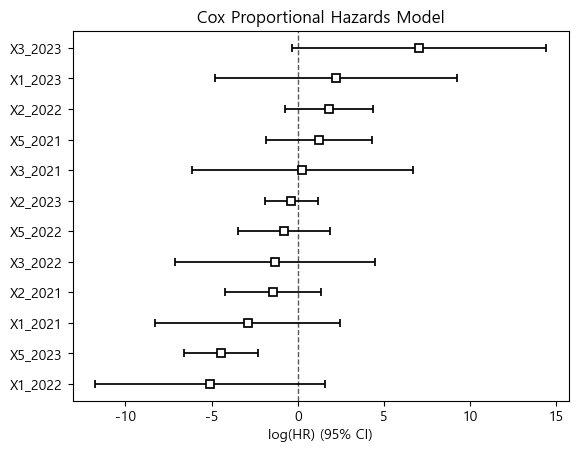

In [212]:
# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_suv, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

# 각 연도별 Cox 적용

<lifelines.CoxPHFitter: fitted with 125 total observations, 11 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 114
   partial log-likelihood = -423.85
         time fit was run = 2025-02-24 08:19:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
EPS        0.00      1.00      0.15           -0.29            0.29                0.75                1.34
BPS        0.25      1.28      0.12            0.01            0.48                1.01                1.62
PER       -0.04      0.96      0.03           -0.10            0.02                0.91                1.02
ROA       -0.13      0.87      0.32           -0.77            0.50                0.46                1.65
ROE        0.03      1.03      0.21           -0.37            0.44                0.69                1.56
X1        -0.01      0.99      0.02           -0.05            0.04                0.95                1.04
X2        -0.05      0.96      0.15           -0.33            0.24                0.72                1.27
X3        -0.70      0.50      0.42           -1.51            0.11                0.22                1.12
X5         0.33      1.40      0.33           -0.32            0.98                0.73                2.68
q         -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

           cmp to     z      p  -log2(p)
covariate                               
EPS          0.00  0.03   0.98      0.03
BPS          0.00  2.07   0.04      4.70
PER          0.00 -1.28   0.20      2.33
ROA          0.00 -0.41   0.68      0.56
ROE          0.00  0.16   0.87      0.20
X1           0.00 -0.26   0.80      0.33
X2           0.00 -0.31   0.76      0.40
X3           0.00 -1.69   0.09      3.46
X5           0.00  1.01   0.31      1.68
q            0.00 -3.03 <0.005      8.66
---
Concordance = 0.67
Partial AIC = 867.70
log-likelihood ratio test = 26.63 on 10 df
-log2(p) of ll-ratio test = 8.39

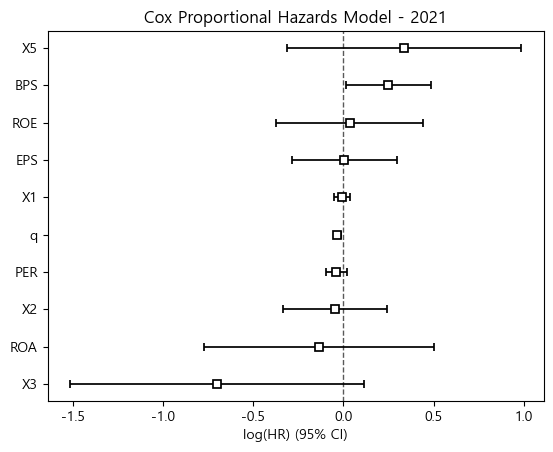

In [213]:
# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_2021_cox, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model - 2021")
plt.show()

<lifelines.CoxPHFitter: fitted with 125 total observations, 11 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 125
number of events observed = 114
   partial log-likelihood = -430.11
         time fit was run = 2025-02-24 08:19:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
EPS        0.37      1.45      0.19           -0.01            0.75                0.99                2.12
BPS        0.08      1.09      0.11           -0.14            0.31                0.87                1.36
PER       -0.06      0.94      0.03           -0.12            0.00                0.89                1.00
ROA       -0.60      0.55      0.25           -1.08           -0.12                0.34                0.88
ROE       -0.09      0.92      0.21           -0.50            0.33                0.60                1.39
X1         0.01      1.01      0.02           -0.03            0.06                0.97                1.06
X2         0.06      1.06      0.15           -0.23            0.35                0.79                1.42
X3         0.11      1.12      0.28           -0.44            0.67                0.64                1.95
X5        -0.41      0.66      0.29           -0.98            0.16                0.37                1.18
q         -0.00      1.00      0.01           -0.03            0.02                0.97                1.02

           cmp to     z    p  -log2(p)
covariate                             
EPS          0.00  1.93 0.05      4.22
BPS          0.00  0.74 0.46      1.12
PER          0.00 -1.87 0.06      4.02
ROA          0.00 -2.46 0.01      6.18
ROE          0.00 -0.41 0.68      0.55
X1           0.00  0.55 0.58      0.79
X2           0.00  0.40 0.69      0.54
X3           0.00  0.39 0.69      0.53
X5           0.00 -1.40 0.16      2.63
q            0.00 -0.06 0.95      0.08
---
Concordance = 0.61
Partial AIC = 880.21
log-likelihood ratio test = 14.12 on 10 df
-log2(p) of ll-ratio test = 2.58

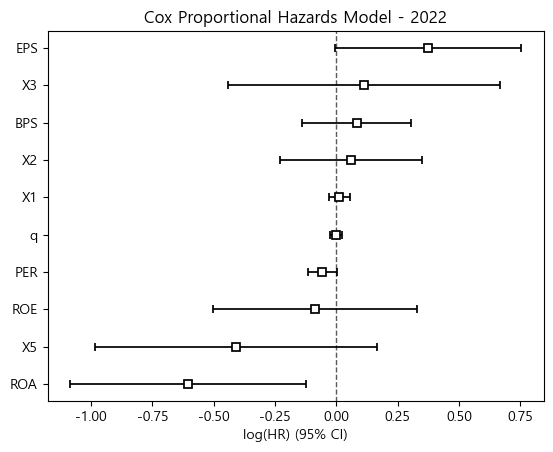

In [214]:
# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_2022_cox, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model - 2022")
plt.show()

<lifelines.CoxPHFitter: fitted with 118 total observations, 4 right-censored observations>
             duration col = '유지기간'
                event col = 'suv'
      baseline estimation = breslow
   number of observations = 118
number of events observed = 114
   partial log-likelihood = -419.45
         time fit was run = 2025-02-24 08:19:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
EPS        0.01      1.01      0.15           -0.29            0.30                0.75                1.35
BPS        0.22      1.24      0.12           -0.02            0.45                0.98                1.57
PER       -0.04      0.96      0.03           -0.10            0.02                0.90                1.02
ROA       -0.07      0.94      0.32           -0.70            0.57                0.49                1.77
ROE        0.03      1.03      0.20           -0.37            0.42                0.69                1.52
X1        -0.00      1.00      0.02           -0.05            0.04                0.95                1.04
X2        -0.07      0.93      0.15           -0.36            0.22                0.70                1.25
X3        -0.68      0.51      0.40           -1.47            0.11                0.23                1.12
X5         0.34      1.40      0.33           -0.31            0.98                0.73                2.66
q         -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99

           cmp to     z      p  -log2(p)
covariate                               
EPS          0.00  0.05   0.96      0.06
BPS          0.00  1.83   0.07      3.88
PER          0.00 -1.35   0.18      2.49
ROA          0.00 -0.20   0.84      0.25
ROE          0.00  0.12   0.90      0.15
X1           0.00 -0.21   0.83      0.26
X2           0.00 -0.47   0.64      0.65
X3           0.00 -1.68   0.09      3.43
X5           0.00  1.02   0.31      1.70
q            0.00 -3.06 <0.005      8.83
---
Concordance = 0.67
Partial AIC = 858.91
log-likelihood ratio test = 26.34 on 10 df
-log2(p) of ll-ratio test = 8.24

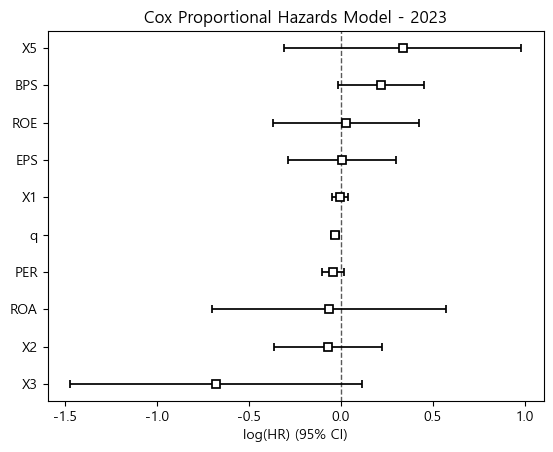

In [215]:
# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
cph.fit(df_2023_cox, duration_col='유지기간', event_col='suv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model - 2023")
plt.show()

# 생존분석_RandomSurvivalTree 사용
- scikit-survival 패키지에서 제공한다.
- 데이터는 df_nums기준
- 생존 일수를 예측 및 점수화


In [216]:
df_nums.head(2)

,종목코드,유지기간,매출액_수익__2016,매출액_수익__2017,매출액_수익__2018,매출액_수익__2019,매출액_수익__2020,영업이익_2016,영업이익_2017,영업이익_2018,영업이익_2019,영업이익_2020,당기순이익_2016,당기순이익_2017,당기순이익_2018,당기순이익_2019,당기순이익_2020,매출액_수익__2021,영업이익_2021,당기순이익_2021,매출액_수익__2022,영업이익_2022,당기순이익_2022,매출액_수익__2023,영업이익_2023,당기순이익_2023,비유동자산_계__2020,비유동자산_계__2021,비유동자산_계__2022,비유동자산_계__2023,유형자산_계__2020,유형자산_계__2021,유형자산_계__2022,유형자산_계__2023,리스자산_2020,리스자산_2021,리스자산_2022,리스자산_2023,무형자산_계__2020,무형자산_계__2021,무형자산_계__2022,무형자산_계__2023,기타의무형자산_계__2020,기타의무형자산_계__2021,기타의무형자산_계__2022,기타의무형자산_계__2023,장기투자자산_2020,장기투자자산_2021,장기투자자산_2022,장기투자자산_2023,매출채권및기타채권_2020,매출채권및기타채권_2020_1,매출채권및기타채권_2021,매출채권및기타채권_2021_1,매출채권및기타채권_2022,매출채권및기타채권_2022_1,매출채권및기타채권_2023,매출채권및기타채권_2023_1,기타금융자산_2020,기타금융자산_2021,기타금융자산_2022,기타금융자산_2023,기타비금융자산_2020,기타비금융자산_2020_1,기타비금융자산_2021,기타비금융자산_2021_1,기타비금융자산_2022,기타비금융자산_2022_1,기타비금융자산_2023,기타비금융자산_2023_1,유동자산_계__2020,유동자산_계__2021,유동자산_계__2022,유동자산_계__2023,재고자산_계__2020,재고자산_계__2021,재고자산_계__2022,재고자산_계__2023,매출채권및기타채권_2020_2,매출채권및기타채권_2020_3,매출채권및기타채권_2021_2,매출채권및기타채권_2021_3,매출채권및기타채권_2022_2,매출채권및기타채권_2022_3,매출채권및기타채권_2023_2,매출채권및기타채권_2023_3,기타비금융자산_2020_2,기타비금융자산_2020_3,기타비금융자산_2021_2,기타비금융자산_2021_3,기타비금융자산_2022_2,기타비금융자산_2022_3,기타비금융자산_2023_2,기타비금융자산_2023_3,현금및현금성자산_2020,현금및현금성자산_2021,현금및현금성자산_2022,현금및현금성자산_2023,자산총계_2020,자산총계_2021,자산총계_2022,자산총계_2023,납입자본_2020,납입자본_2021,납입자본_2022,납입자본_2023,자본금_2020,자본금_2021,자본금_2022,자본금_2023,이익잉여금_2020,이익잉여금_2021,이익잉여금_2022,이익잉여금_2023,기타자본구성요소_2020,기타자본구성요소_2021,기타자본구성요소_2022,기타자본구성요소_2023,기타포괄손익누계액_2020,기타포괄손익누계액_2021,기타포괄손익누계액_2022,기타포괄손익누계액_2023,기타자본구성_2020,기타자본구성_2021,기타자본구성_2022,기타자본구성_2023,자본총계_2020,자본총계_2021,자본총계_2022,자본총계_2023,_평균발행주식수__2020,_평균발행주식수__2021,_평균발행주식수__2022,_평균발행주식수__2023,비유동부채_계__2020,비유동부채_계__2021,비유동부채_계__2022,비유동부채_계__2023,매입채무및기타채무_2020,매입채무및기타채무_2020_1,매입채무및기타채무_2021,매입채무및기타채무_2021_1,매입채무및기타채무_2022,매입채무및기타채무_2022_1,매입채무및기타채무_2023,매입채무및기타채무_2023_1,비유동차입부채_2020,비유동차입부채_2021,비유동차입부채_2022,비유동차입부채_2023,장기사채_계__2020,장기사채_계__2021,장기사채_계__2022,장기사채_계__2023,장기차입금_계__2020,장기차입금_계__2021,장기차입금_계__2022,장기차입금_계__2023,기타금융부채_2020,기타금융부채_2020_1,기타금융부채_2021,기타금융부채_2021_1,기타금융부채_2022,기타금융부채_2022_1,기타금융부채_2023,기타금융부채_2023_1,퇴직급여채무_2020,퇴직급여채무_2021,퇴직급여채무_2022,퇴직급여채무_2023,유동부채_계__2020,유동부채_계__2021,유동부채_계__2022,유동부채_계__2023,매입채무및기타채무_2020_2,매입채무및기타채무_2020_3,매입채무및기타채무_2021_2,매입채무및기타채무_2021_3,매입채무및기타채무_2022_2,매입채무및기타채무_2022_3,매입채무및기타채무_2023_2,매입채무및기타채무_2023_3,유동차입부채_2020,유동차입부채_2021,유동차입부채_2022,유동차입부채_2023,단기차입금_2020,단기차입금_2021,단기차입금_2022,단기차입금_2023,유동성장기부채_2020,유동성장기부채_2021,유동성장기부채_2022,유동성장기부채_2023,유동성사채_2020,유동성사채_2021,유동성사채_2022,유동성사채_2023,기타비금융부채_2020,기타비금융부채_2020_1,기타비금융부채_2021,기타비금융부채_2021_1,기타비금융부채_2022,기타비금융부채_2022_1,기타비금융부채_2023,기타비금융부채_2023_1,단기충당부채_2020,단기충당부채_2021,단기충당부채_2022,단기충당부채_2023,부채총계_2020,부채총계_2021,부채총계_2022,부채총계_2023,부채와자본총계_2020,부채와자본총계_2021,부채와자본총계_2022,부채와자본총계_2023,"매출채권_공사,영업미수__2020","매출채권_공사,영업미수__2021","매출채권_공사,영업미수__2022","매출채권_공사,영업미수__2023",유형자산_2020,유형자산_2021,유형자산_2022,유형자산_2023,매입채무_2020,매입채무_2021,매입채무_2022,매입채무_2023,유동성장기차입금_2020,유동성장기차입금_2021,유동성장기차입금_2022,유동성장기차입금_2023,기타유동성장기부채_2020,기타유동성장기부채_2021,기타유동성장기부채_2022,기타유동성장기부채_2023,기타유동부채_2020,기타유동부채_2021,기타유동부채_2022,기타유동부채_2023,기타비유동부채_2020,기타비유동부채_2021,기타비유동부채_2022,기타비유동부채_2023,단기투자자산_2020,단기투자자산_2021,단기투자자산_2022,단기투자자산_2023,장기충당부채_계__2020,장기충당부채_계__2021,장기충당부채_계__2022,장기충당부채_계__2023,기타금융부채_2020_2,기타금융부채_2020_3,기타금융부채_2021_2,기타금융부채_2021_3,기타금융부채_2022_2,기타금융부채_2022_3,기타금융부채_2023_2,기타금융부채_2023_3,건설중인자산_2020,건설중인자산_2021,건설중인자산_2022,건설중인자산_2023,기타비금융부채_2020_2,기타비금융부채_2020_3,기타비금융부채_2021_2,기타비금융부채_2021_3,기타비금융부채_2022_2,기타비금융부채_2022_3,기타비금융부채_2023_2,기타비금융부채_2023_3,시가총액_2020,상장주식수_2020,시가총액_2021,상장주식수_2021,시가총액_2022,상장주식수_2022,시가총액_2023,상장주식수_2023,운전자산_2020,운전자산_2021,운전자산_2022,운전자산_2023,운전자본_2020,운전자본_2021,운전자본_2022,운전자본_2023,X1_2020,X2_2020,X4_2020,X5_2020,q_2020,X1_2021,X2_2021,X4_2021,X5_2021,q_2021,X1_2022,X2_2022,X4_2022,X5_2022,q_2022,X1_2023,X2_2023,X4_2023,X5_2023,q_2023,X3_2020,X3_2021,X3_2022,X3_2023,suv
0,199870,825,65842922.0,40997

In [217]:
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.preprocessing import OneHotEncoder

# 생존 정보 변환 (event: 사망 여부, time: 생존 기간)
y = Surv.from_dataframe(event='suv',time='유지기간', data=df_nums)

# 그 외 함수들
X = df_nums.drop(columns=['유지기간', 'suv'])

# 훈련/테스트 데이터 분할 -> 굳이 필요하지 않은가?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

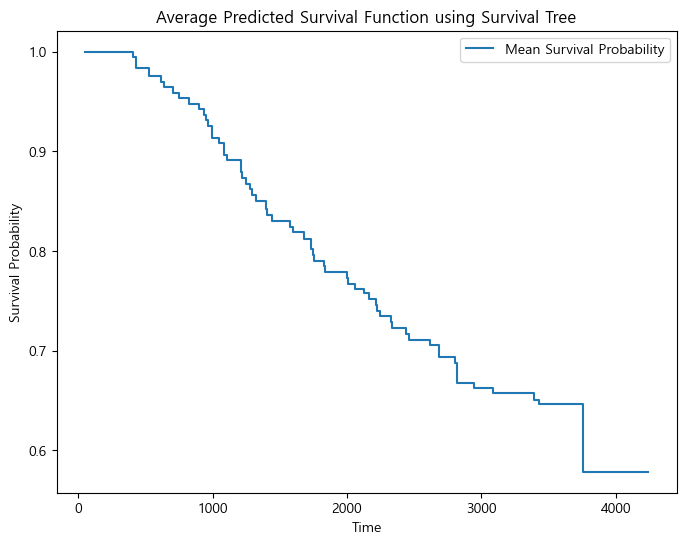

In [218]:
# 생존 트리 모델 학습
surv_tree = RandomSurvivalForest(n_estimators=100,
                                 max_depth=None,
                                 random_state=42)
surv_tree.fit(X,y)

# 전체 테스트 데이터에 대한 생존 확률 예측
survival_functions = surv_tree.predict_survival_function(X, return_array=False)

# 모든 샘플의 평균 생존 확률 계산
time_points = np.unique(np.hstack([fn.x for fn in survival_functions]))  # 모든 시간 지점 추출
mean_survival_probs = np.zeros_like(time_points, dtype=np.float64)

# 각 시간 지점에서 모든 샘플의 평균 생존 확률을 계산
for fn in survival_functions:
    mean_survival_probs += np.interp(time_points, fn.x, fn.y)  # 선형 보간
mean_survival_probs /= len(survival_functions)  # 평균 계산

# 5. 시각화
plt.figure(figsize=(8, 6))
plt.step(time_points, mean_survival_probs, where="post", label="Mean Survival Probability")

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Average Predicted Survival Function using Survival Tree")
plt.legend()
plt.show()

In [219]:
predictions = surv_tree.predict(X)

score = surv_tree.score(X, y)
print("ConCordance index", score)

ConCordance index 0.9386485313268702


### 생존 일수 예측
- 기존 전체 숫자화 데이터 사용 

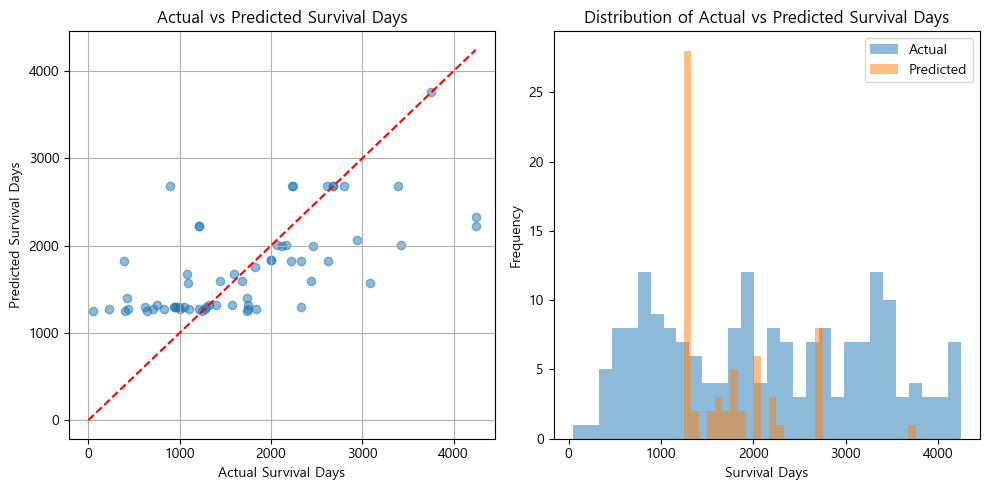

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# 1. 데이터 준비 (df_nums: 기존 데이터)
y = Surv.from_dataframe(event='suv', time='유지기간', data=df_nums)
X = df_nums.drop(columns=['유지기간', 'suv', '종목코드'])

# 2. 훈련/테스트 데이터 분할
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 랜덤 생존 숲 모델 학습
rsf = RandomSurvivalForest(n_estimators=200, 
                           max_depth=10,
                           min_samples_split=10,
                           min_samples_leaf=5,
                           random_state=42)
rsf.fit(X, y)

# 4. 테스트 데이터에 대한 생존 확률 예측
survival_functions = rsf.predict_survival_function(X, return_array=False)

predicted_survival_days = []
for fn in survival_functions:
    if np.any(fn.y <= 0.5):  # 50% 이하 지점이 존재하는 경우
        median_index = np.where(fn.y <= 0.5)[0][0]
        predicted_days = fn.x[median_index]
    else:
        predicted_days = np.nan  # NaN 처리 (이후 평균으로 대체)
    
    predicted_survival_days.append(predicted_days)

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame({
    "실제 생존일수": y["유지기간"],  # 실제 생존 일수
    "예측 생존일수": predicted_survival_days  # 모델 예측값
})

# 6. 성능 평가 및 시각화
plt.figure(figsize=(10, 5))

# (1) 실제 vs. 예측 생존일수 산점도
plt.subplot(1, 2, 1)
plt.scatter(results_df["실제 생존일수"], results_df["예측 생존일수"], alpha=0.5)
plt.plot([0, max(results_df["실제 생존일수"])], [0, max(results_df["실제 생존일수"])], 'r--')  # 대각선 기준선
plt.xlabel("Actual Survival Days")
plt.ylabel("Predicted Survival Days")
plt.title("Actual vs Predicted Survival Days")
plt.grid()

# (2) 히스토그램 비교
plt.subplot(1, 2, 2)
plt.hist(results_df["실제 생존일수"], bins=30, alpha=0.5, label="Actual")
plt.hist(results_df["예측 생존일수"], bins=30, alpha=0.5, label="Predicted")
plt.xlabel("Survival Days")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs Predicted Survival Days")
plt.legend()

plt.tight_layout()
plt.show()


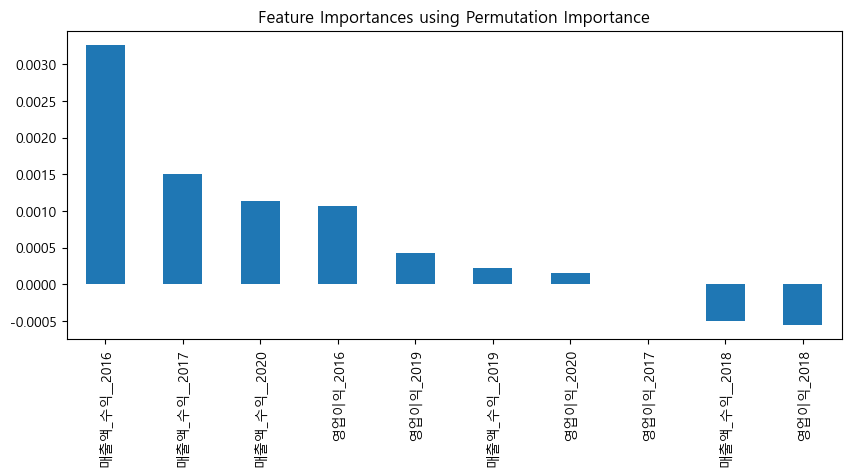

In [221]:
# 필요한 라이브러리 임포트
from sklearn.inspection import permutation_importance

# Permutation Importance 계산
result = permutation_importance(rsf, X, y, n_repeats=10, random_state=42)

# 중요도 결과를 데이터프레임으로 변환
importances = pd.Series(result.importances_mean, index=X.columns)
importances_10 = importances.head(10)
# 중요도 시각화
importances_10.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))
plt.title("Feature Importances using Permutation Importance")
plt.show()

In [222]:
def analyze_survival(df):
    # 1. 데이터 준비 (df_nums: 기존 데이터)
    y = Surv.from_dataframe(event='suv', time='유지기간', data=df)
    X = df.drop(columns=['유지기간', 'suv'])

    # 2. 훈련/테스트 데이터 분할
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. 랜덤 생존 숲 모델 학습
    rsf = RandomSurvivalForest(n_estimators=200, 
                               max_depth=10,
                               min_samples_split=10,
                               min_samples_leaf=5,
                               random_state=42)
    rsf.fit(X, y)

    # 4. 테스트 데이터에 대한 생존 확률 예측
    survival_functions = rsf.predict_survival_function(X, return_array=False)

    predicted_survival_days = []
    for fn in survival_functions:
        if np.any(fn.y <= 0.5):  # 50% 이하 지점이 존재하는 경우
            median_index = np.where(fn.y <= 0.5)[0][0]
            predicted_days = fn.x[median_index]
        else:
            predicted_days = np.nan  # NaN 처리 (이후 평균으로 대체)
        
        predicted_survival_days.append(predicted_days)

    # 결과를 데이터프레임으로 정리
    results_df = pd.DataFrame({
        "실제 생존일수": y["유지기간"],  # 실제 생존 일수
        "예측 생존일수": predicted_survival_days  # 모델 예측값
    })

    # 6. 성능 평가 및 시각화
    plt.figure(figsize=(10, 5))

    # (1) 실제 vs. 예측 생존일수 산점도
    plt.subplot(1, 2, 1)
    plt.scatter(results_df["실제 생존일수"], results_df["예측 생존일수"], alpha=0.5)
    plt.plot([0, max(results_df["실제 생존일수"])], [0, max(results_df["실제 생존일수"])], 'r--')  # 대각선 기준선
    plt.xlabel("Actual Survival Days")
    plt.ylabel("Predicted Survival Days")
    plt.title("Actual vs Predicted Survival Days")
    plt.grid()

    # (2) 히스토그램 비교
    plt.subplot(1, 2, 2)
    plt.hist(results_df["실제 생존일수"], bins=30, alpha=0.5, label="Actual")
    plt.hist(results_df["예측 생존일수"], bins=30, alpha=0.5, label="Predicted")
    plt.xlabel("Survival Days")
    plt.ylabel("Frequency")
    plt.title("Distribution of Actual vs Predicted Survival Days")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Permutation Importance 계산
    result = permutation_importance(rsf, X, y, n_repeats=10, random_state=42)

    # 중요도 결과를 데이터프레임으로 변환
    importances = pd.Series(result.importances_mean, index=X.columns)
    importances_10 = importances.head(10)
    # 중요도 시각화
    importances_10.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))
    plt.title("Feature Importances using Permutation Importance")
    plt.show()


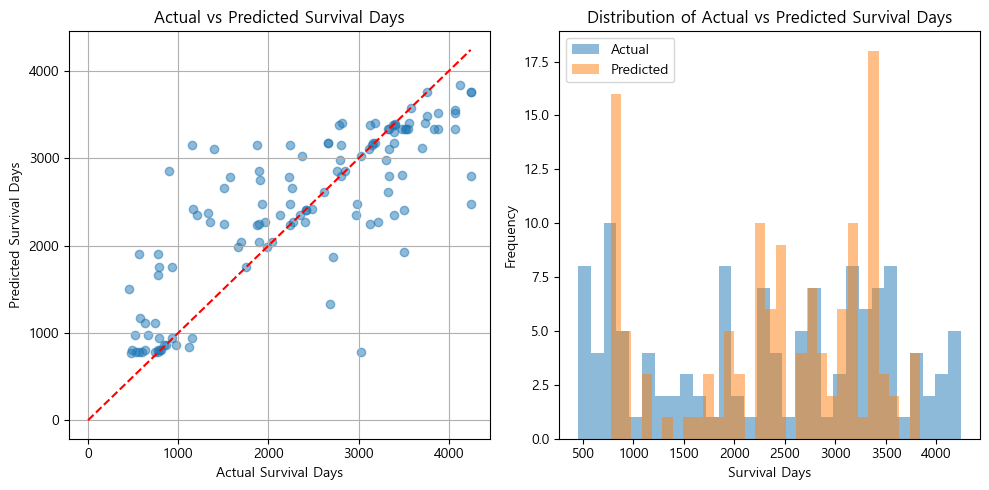

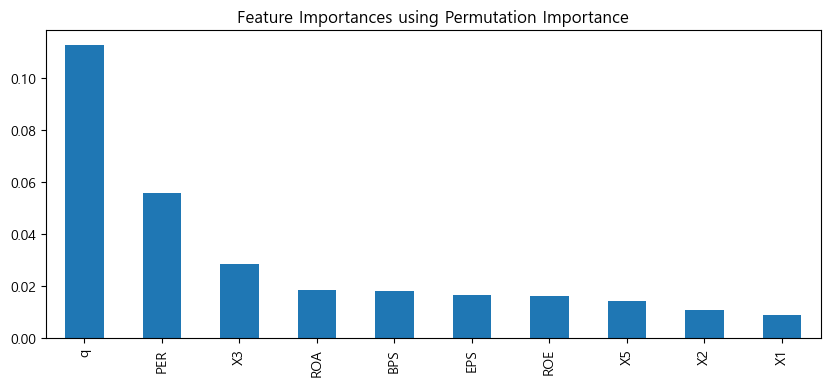

In [223]:
analyze_survival(df_2021_cox)

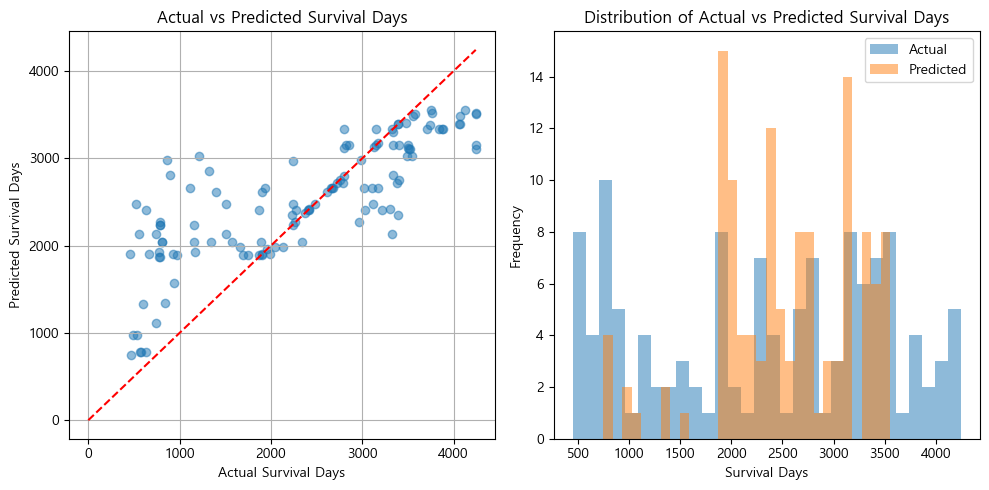

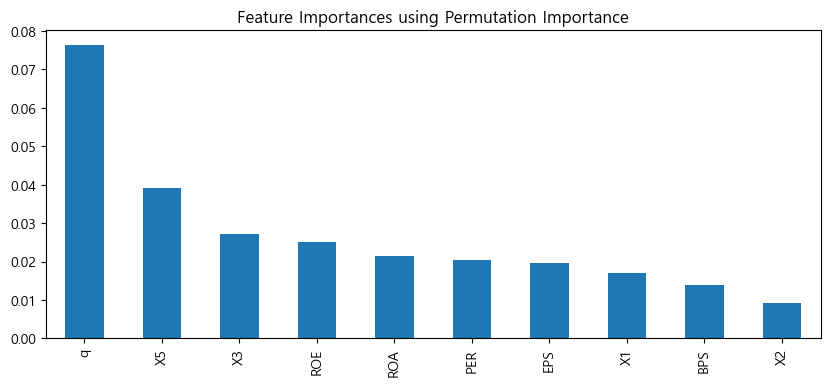

In [224]:
analyze_survival(df_2022_cox)

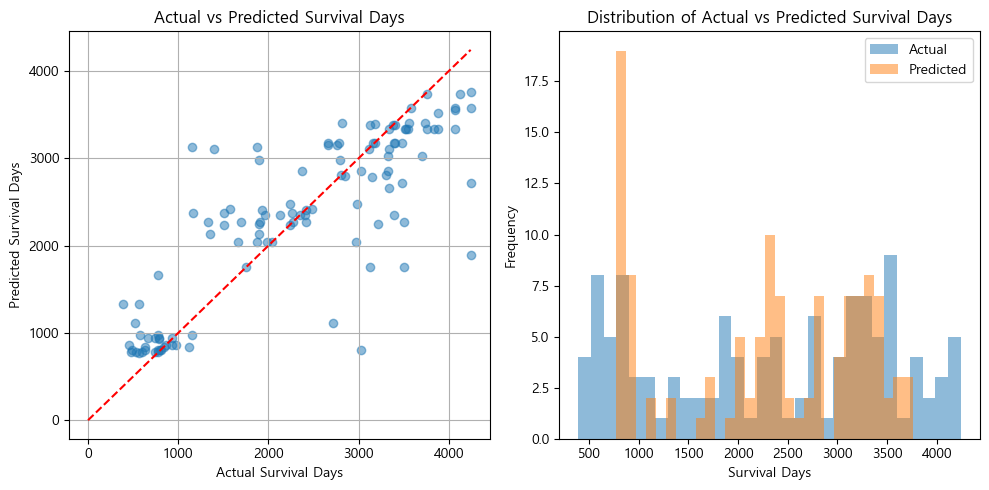

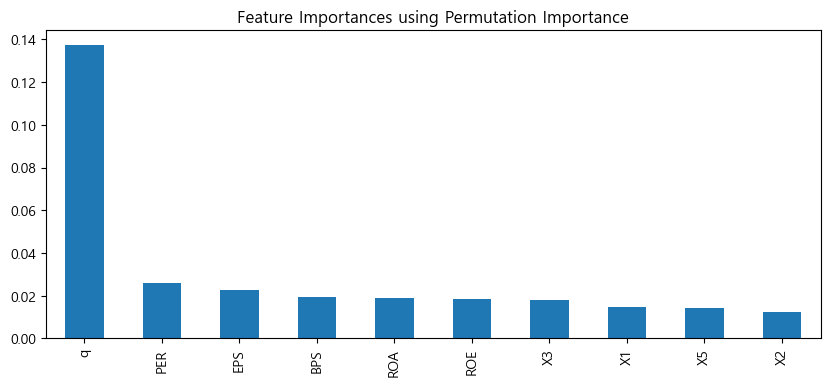

In [225]:
analyze_survival(df_2023_cox)

# ML 사용
- 트리, XGBoost, Catboost, LightGBM 적용
- LGBM은 뭔가 문제가 있는 듯 함.

In [226]:
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def model_evaluation_ML(df):

    # 특성과 타겟 분리
    X = df.drop(columns=['suv'])
    y = df['suv']

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 0. 랜덤 포레스트 분류 모델 생성 및 훈련
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측 수행
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # 정확도 평가
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random Tree 모델 정확도: {accuracy:.2f}")

    # ROC 커브 및 AUC 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # 1. XGBoost 모델 생성 및 훈련
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # 예측 수행
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # 정확도 평가
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost 모델 정확도: {accuracy_xgb:.2f}")

    # ROC 커브 및 AUC 계산
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

    # 2. CatBoost 모델 생성 및 훈련
    cat_model = CatBoostClassifier(silent=True)
    cat_model.fit(X_train, y_train)

    # 예측 수행
    y_pred_cat = cat_model.predict(X_test)
    y_pred_prob_cat = cat_model.predict_proba(X_test)[:, 1]

    # 정확도 평가
    accuracy_cat = accuracy_score(y_test, y_pred_cat)
    print(f"CatBoost 모델 정확도: {accuracy_cat:.2f}")

    # ROC 커브 및 AUC 계산
    fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_prob_cat)
    roc_auc_cat = auc(fpr_cat, tpr_cat)

    # 3. LightGBM 모델 생성 및 훈련
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)

    # 예측 수행
    y_pred_lgb = lgb_model.predict(X_test)
    y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

    # 정확도 평가
    accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
    print(f"LightGBM 모델 정확도: {accuracy_lgb:.2f}")

    # ROC 커브 및 AUC 계산
    fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_prob_lgb)
    roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBoost AUC = {roc_auc_xgb:.2f}')
    plt.plot(fpr_cat, tpr_cat, color='green', label=f'CatBoost AUC = {roc_auc_cat:.2f}')
    plt.plot(fpr, tpr, color='yellow', label=f'랜덤 포레스트 AUC = {roc_auc:.2f}')
    plt.plot(fpr_lgb, tpr_lgb, color='red', label=f'LightGBM AUC = {roc_auc_lgb:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
    
    # SHAP 값 계산 및 시각화
    def plot_shap_summary(model, X, model_name):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
    
        plt.figure(figsize=(6, 4))
        shap.summary_plot(shap_values, X)#, plot_type="bar")
        plt.title(f"{model_name} SHAP Feature Importance")
        plt.show()

    # 개별 모델 SHAP 해석 실행
    plot_shap_summary(model, X, "RandomForest")
    plot_shap_summary(xgb_model, X, "XGBoost")
    plot_shap_summary(cat_model, X, "CatBoost")
    plot_shap_summary(lgb_model, X, "LightGBM")

    plt.tight_layout()
    plt.show()


### 2021년

In [227]:
df_2021_index.columns

Index(['유지기간', 'suv', 'EPS', 'BPS', 'PER', 'PBR', 'ROA', 'ROE', 'X1', 'X2',
       'X3', 'X4', 'X5', 'q'],
      dtype='object')

Random Tree 모델 정확도: 0.83
XGBoost 모델 정확도: 0.86


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.86
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

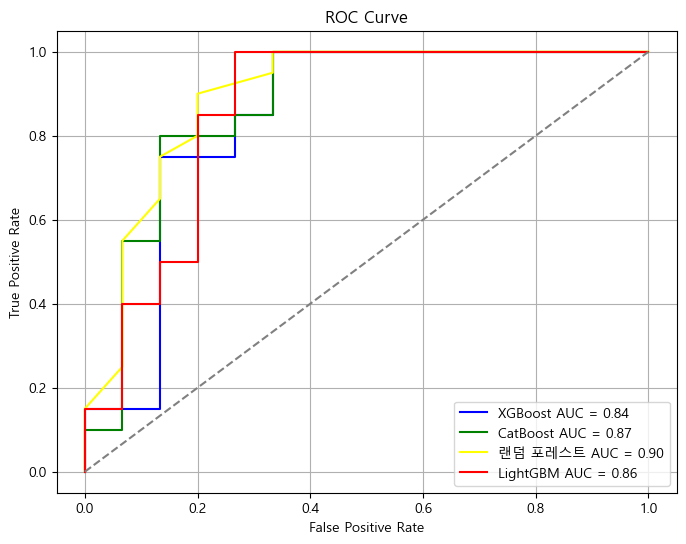

<Figure size 600x400 with 0 Axes>

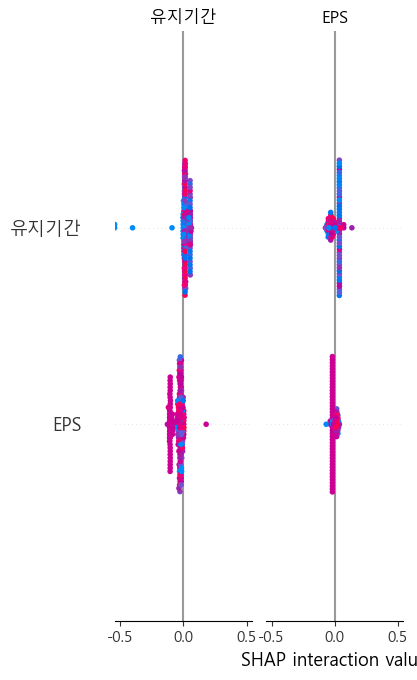

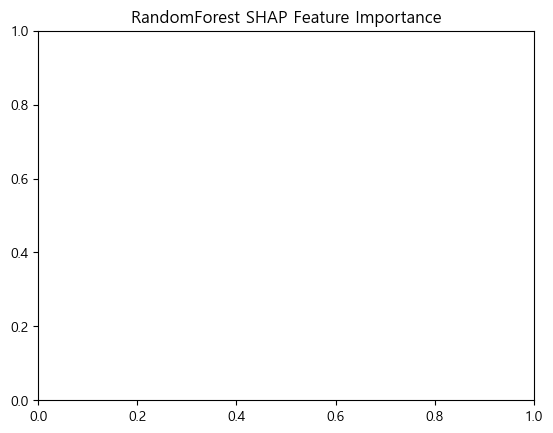

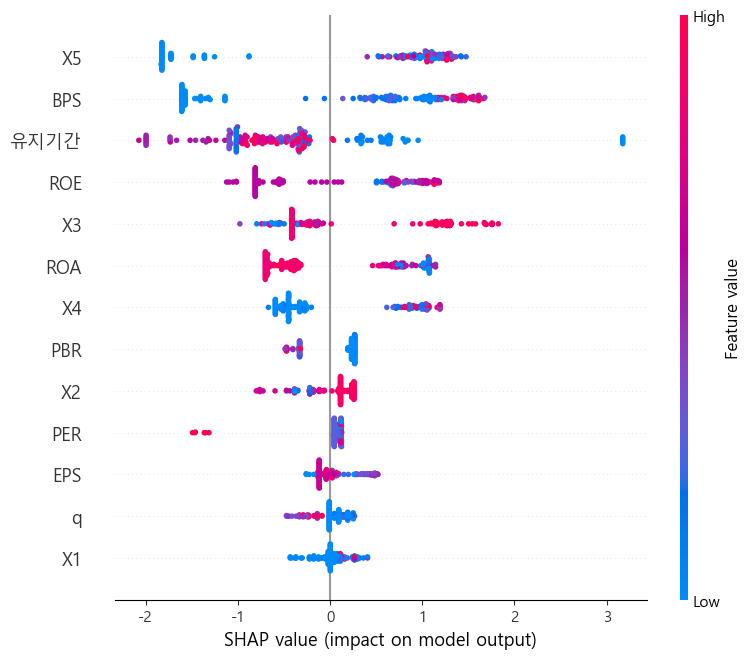

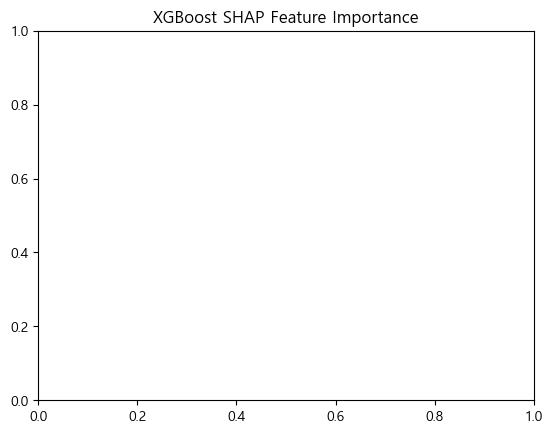

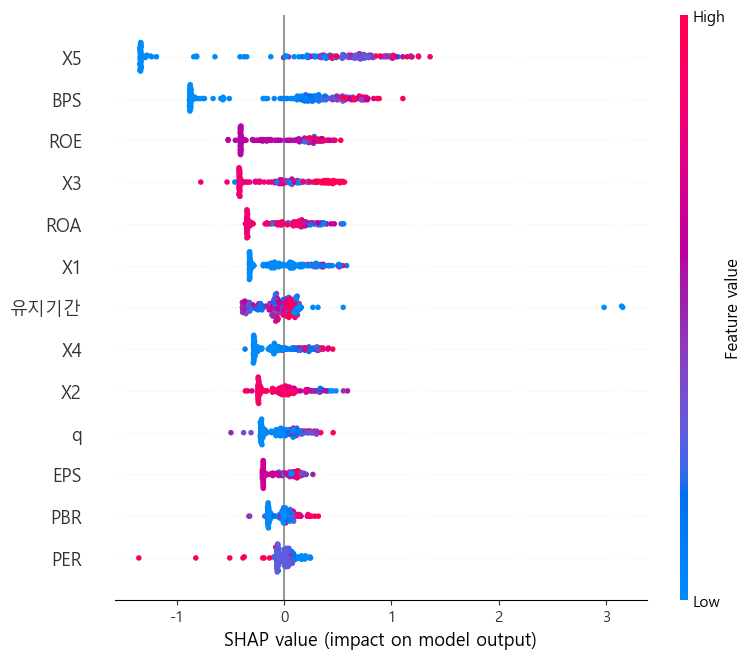

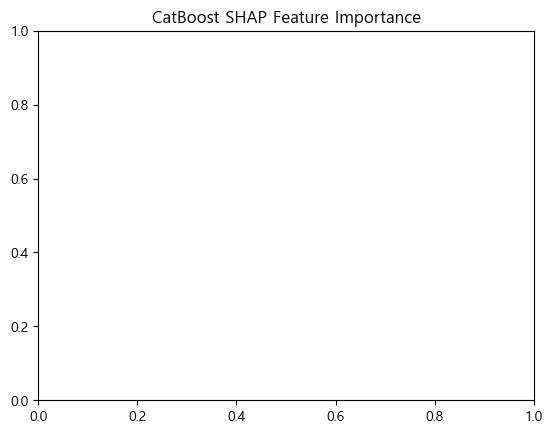

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


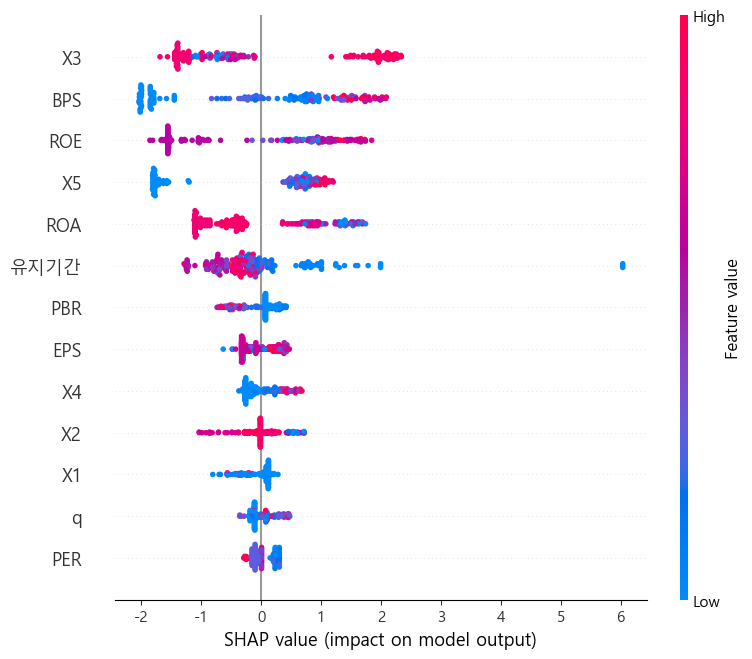

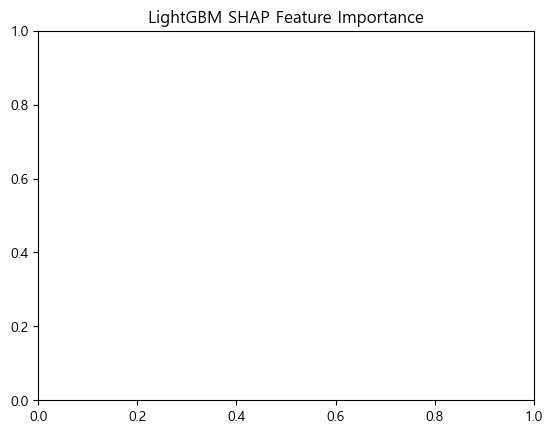

<Figure size 640x480 with 0 Axes>

In [228]:
model_evaluation_ML(df_2021_index)

Random Tree 모델 정확도: 0.86
XGBoost 모델 정확도: 0.83


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.86
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

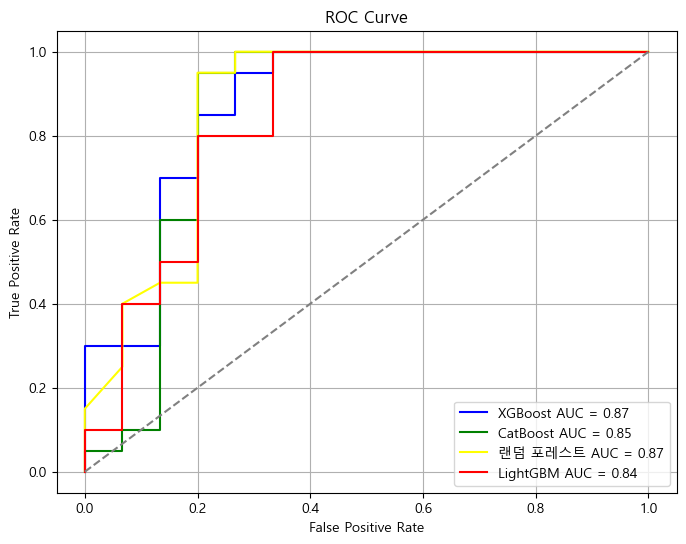

<Figure size 600x400 with 0 Axes>

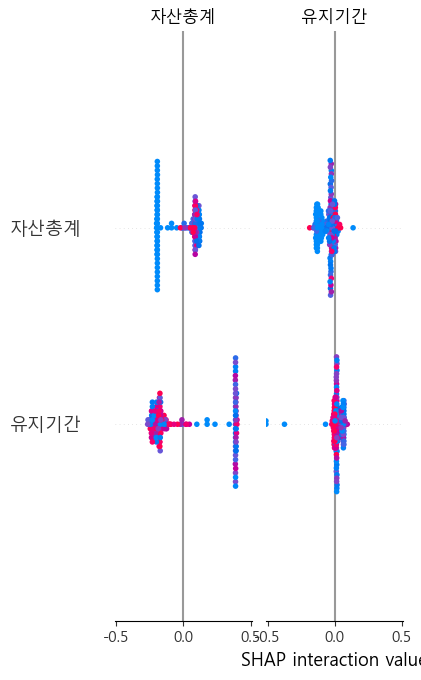

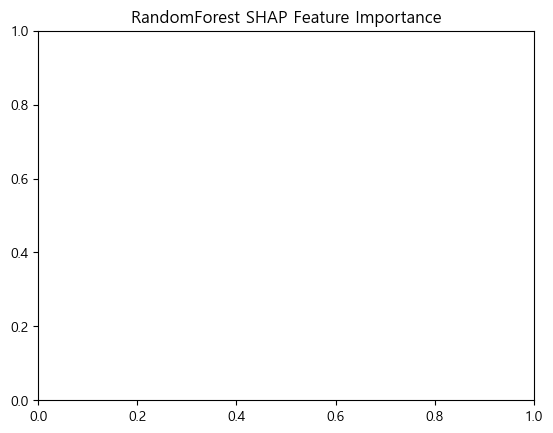

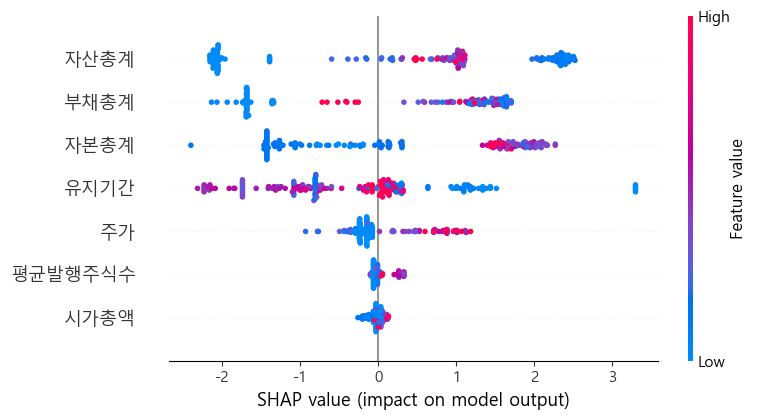

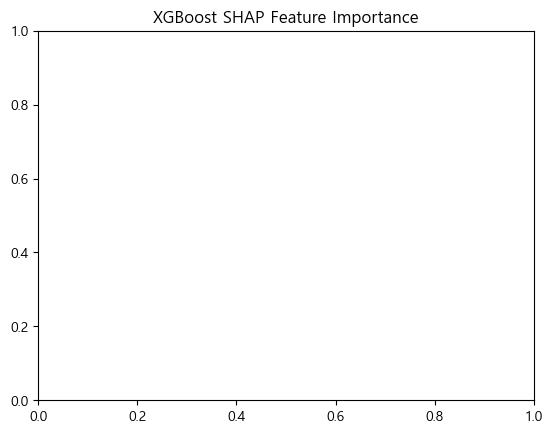

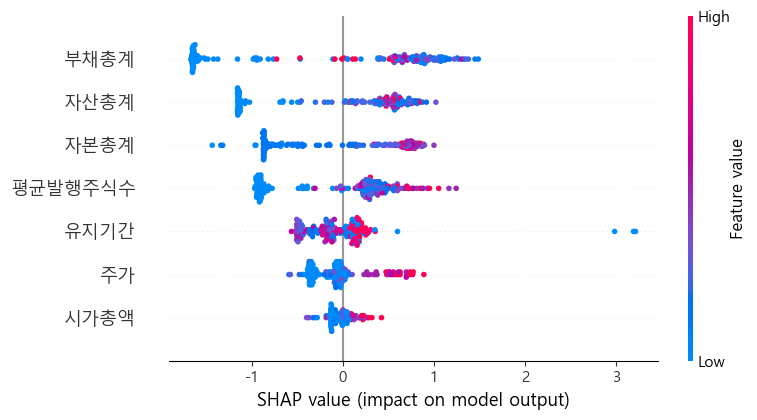

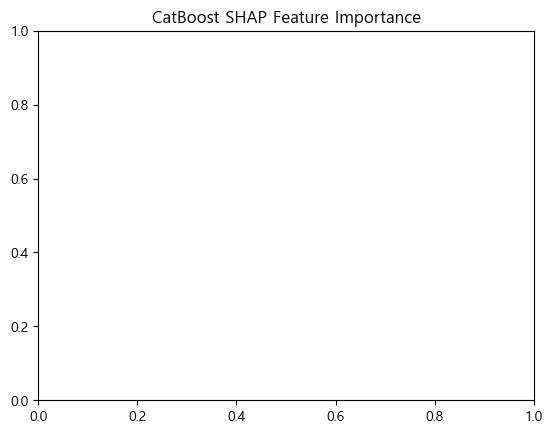

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


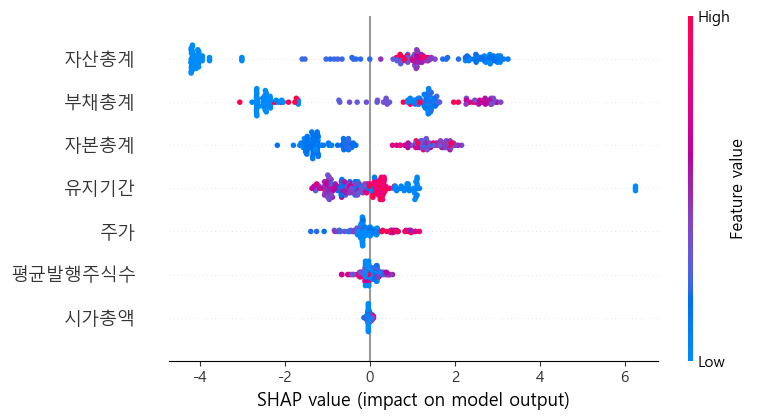

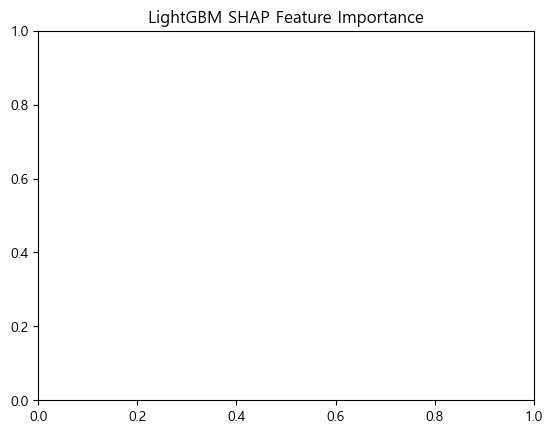

<Figure size 640x480 with 0 Axes>

In [229]:
model_evaluation_ML(df_2021_capital)

### 2022년

Random Tree 모델 정확도: 0.83
XGBoost 모델 정확도: 0.83


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.83
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

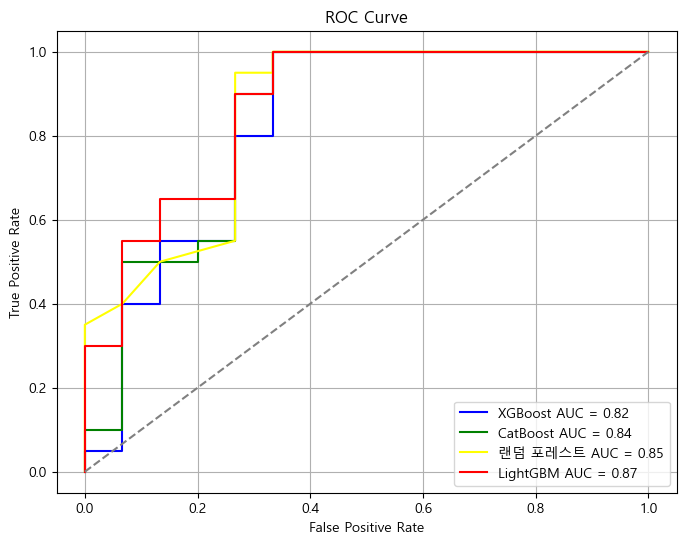

<Figure size 600x400 with 0 Axes>

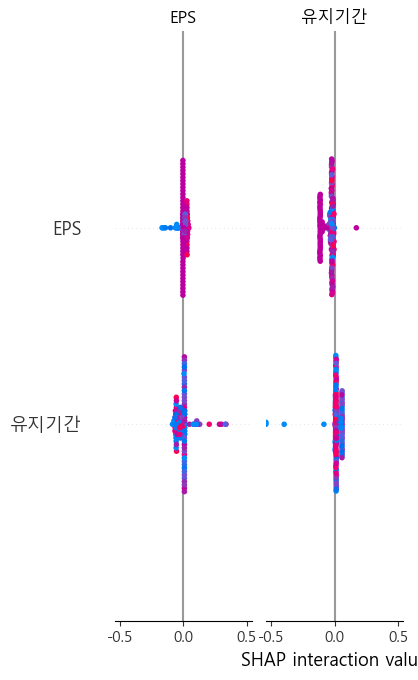

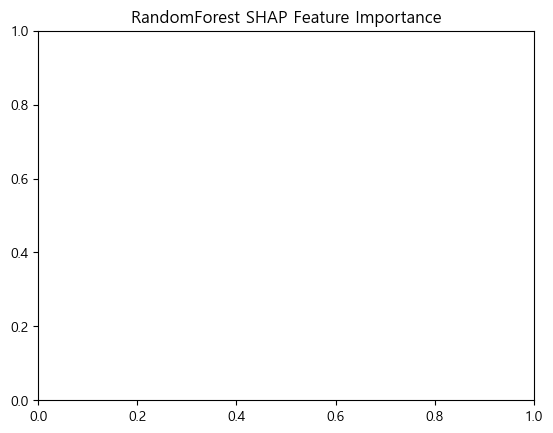

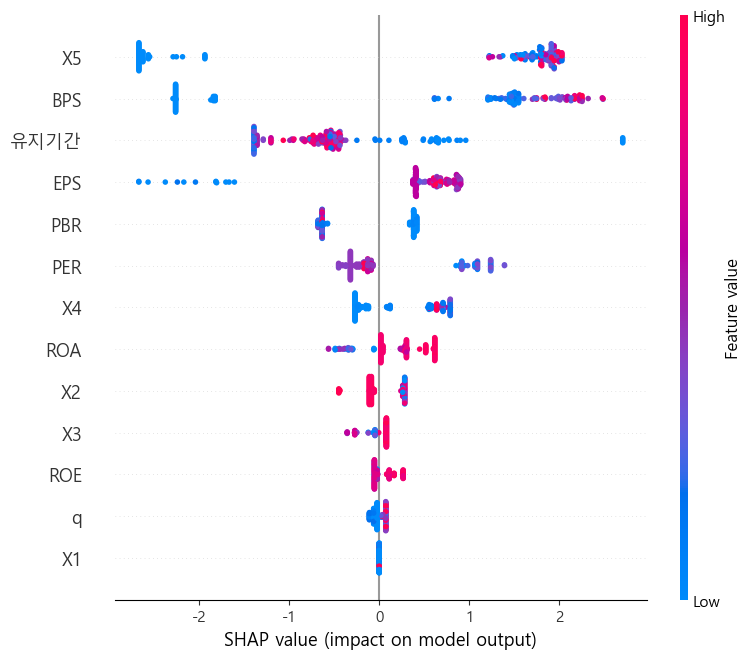

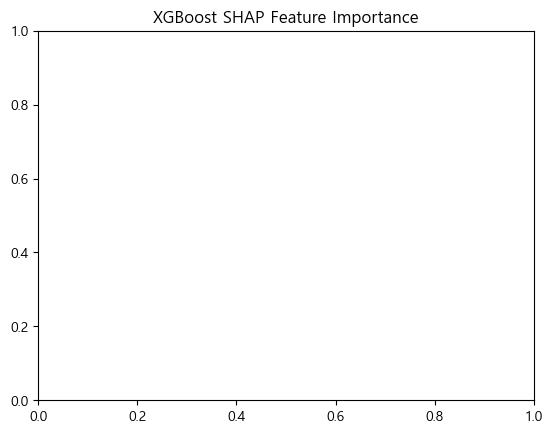

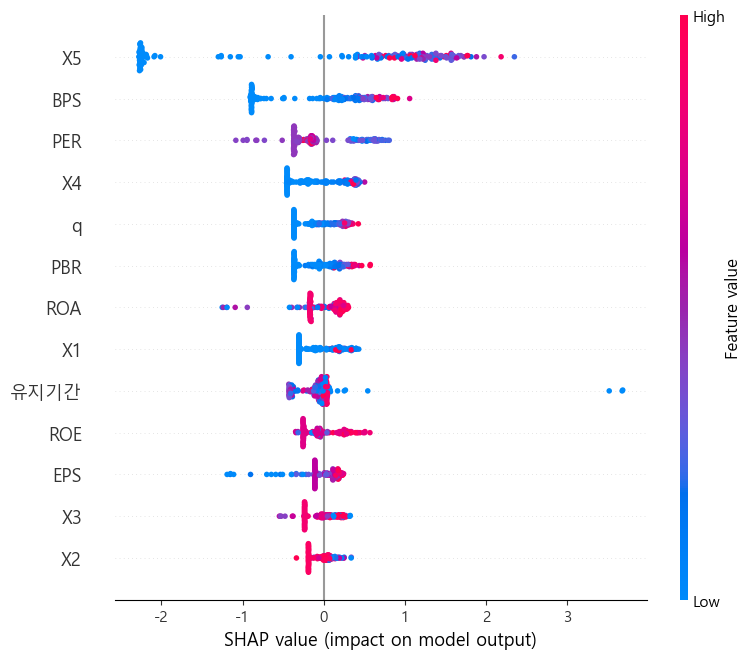

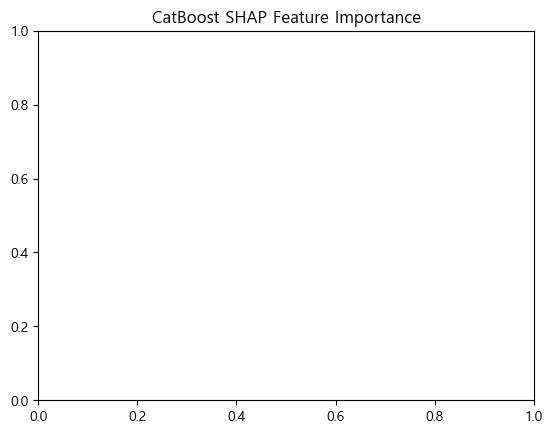

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


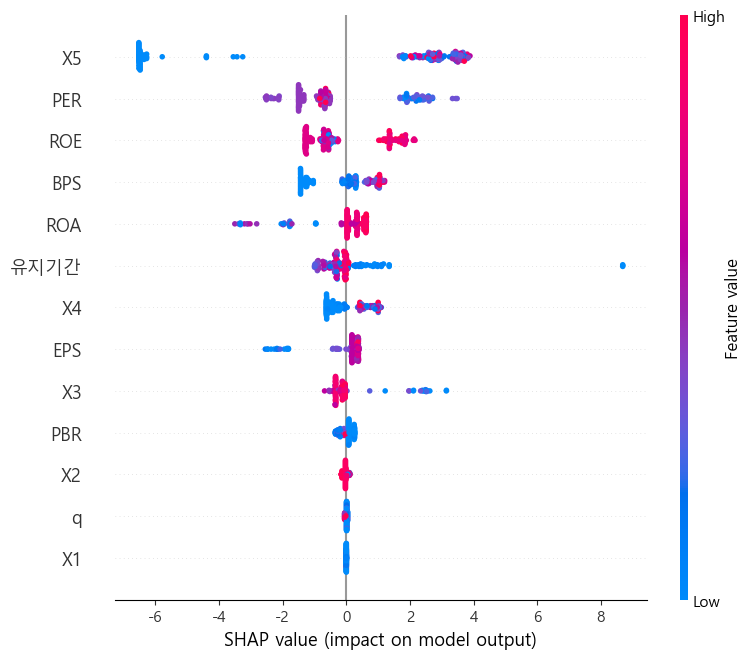

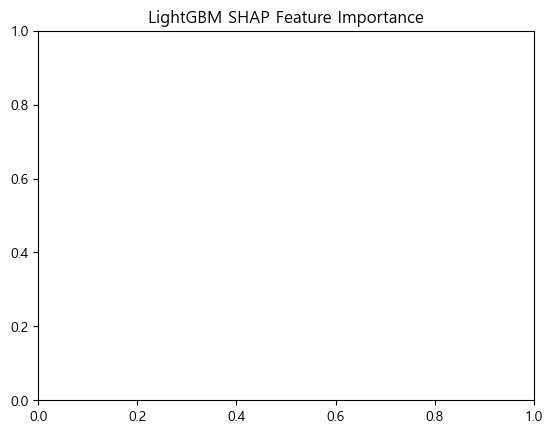

<Figure size 640x480 with 0 Axes>

In [230]:
model_evaluation_ML(df_2022_index)

Random Tree 모델 정확도: 0.86
XGBoost 모델 정확도: 0.86


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.83
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

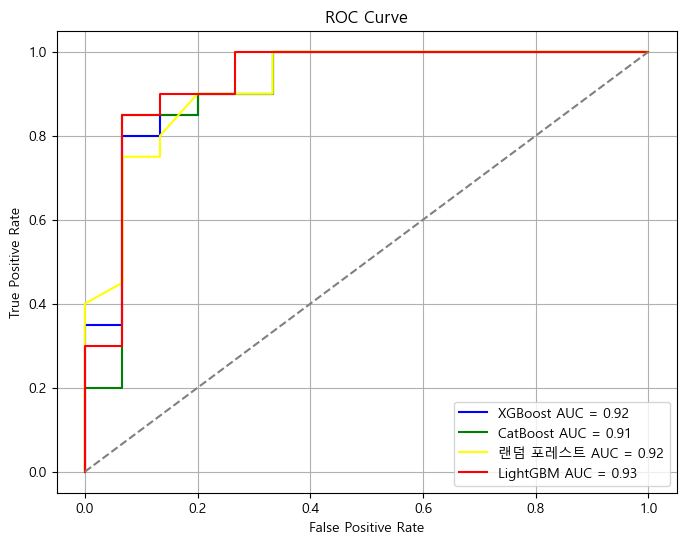

<Figure size 600x400 with 0 Axes>

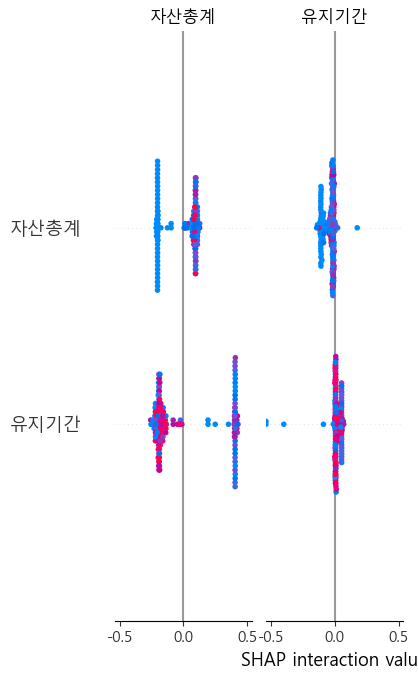

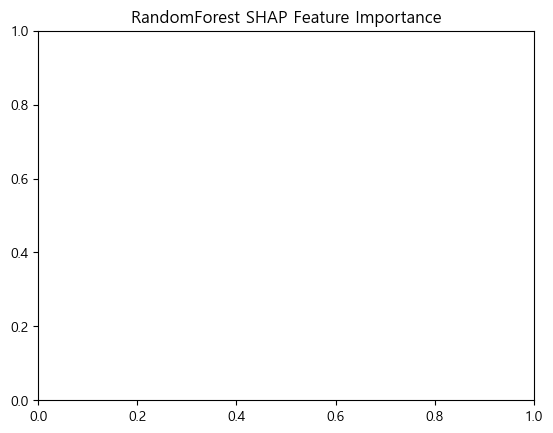

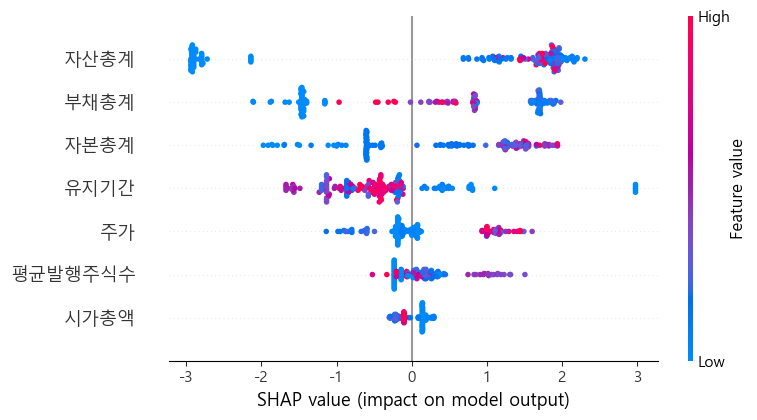

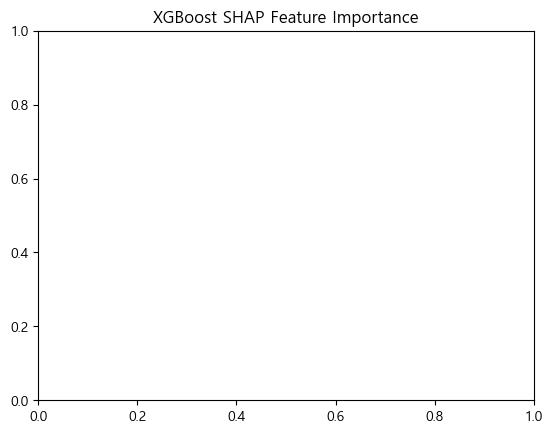

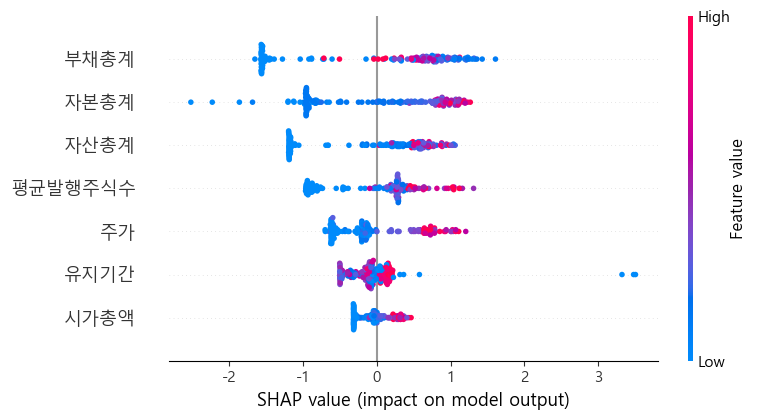

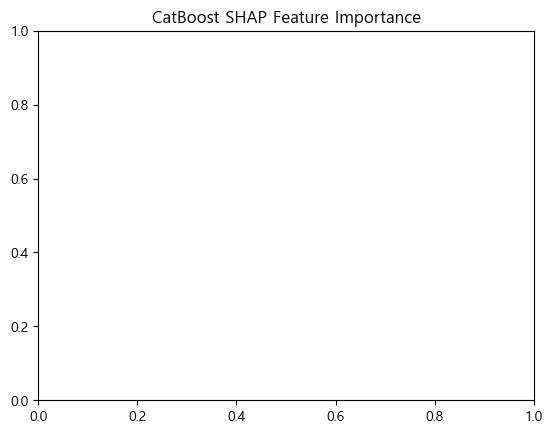

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


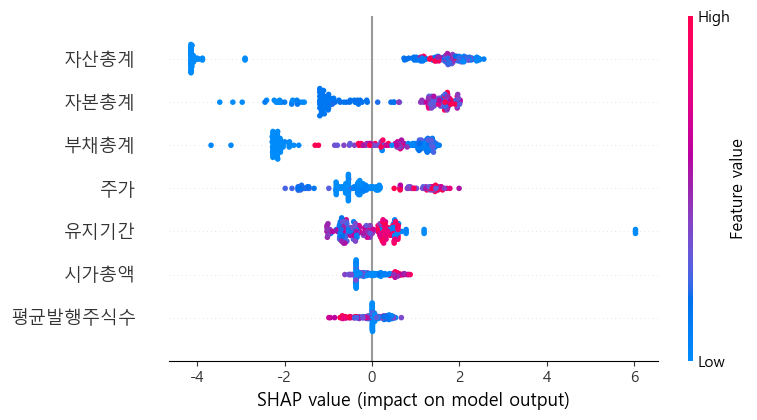

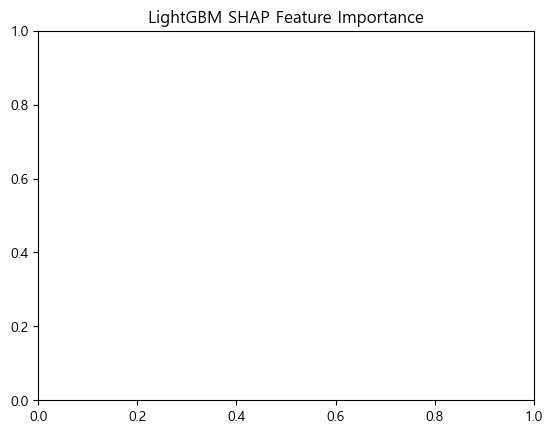

<Figure size 640x480 with 0 Axes>

In [231]:
model_evaluation_ML(df_2022_capital)

### 2023년 

Random Tree 모델 정확도: 0.89
XGBoost 모델 정확도: 0.91


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.91
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

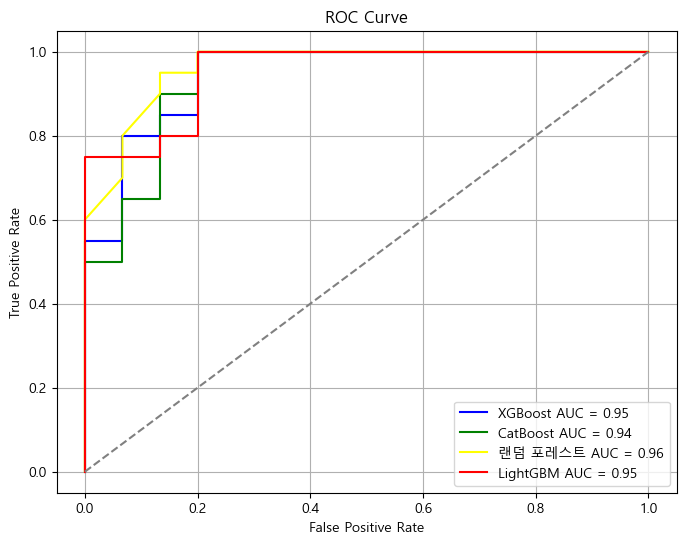

<Figure size 600x400 with 0 Axes>

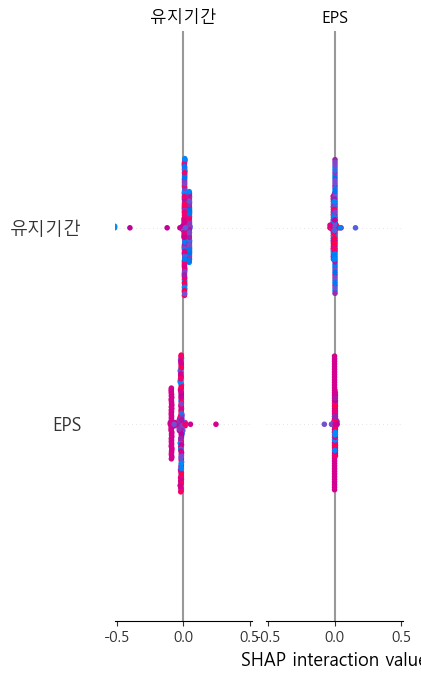

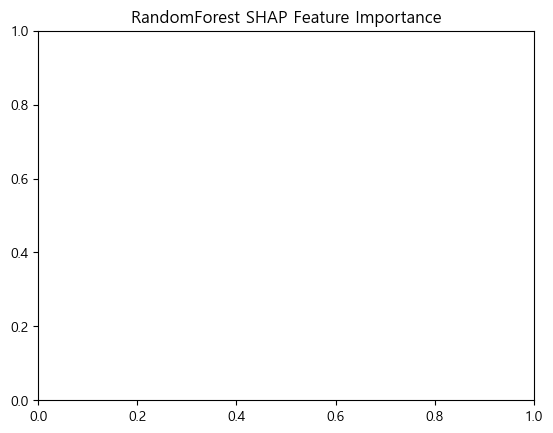

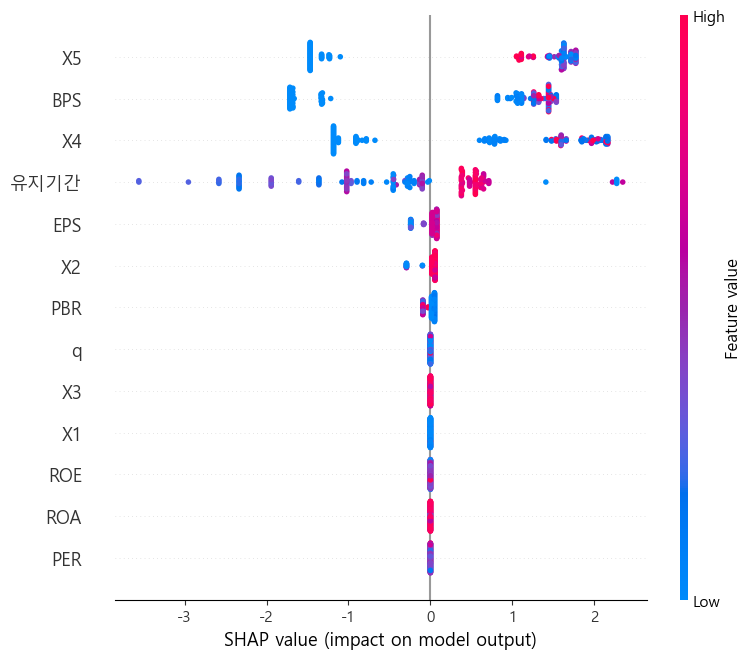

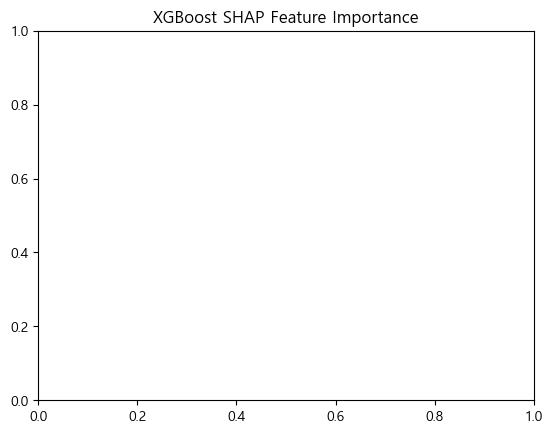

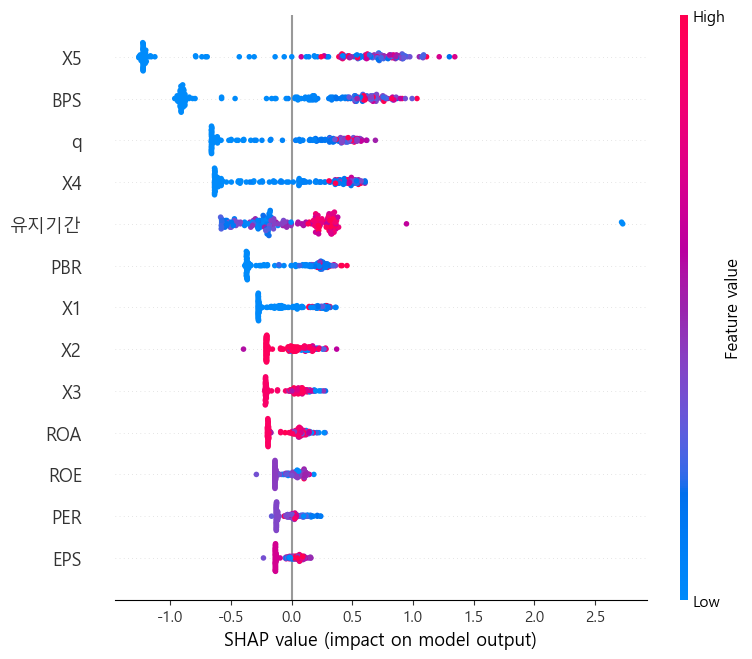

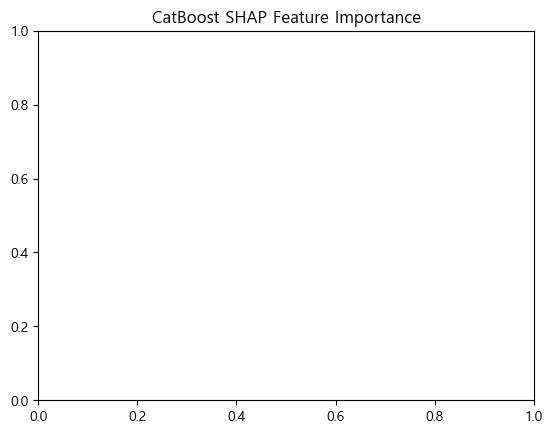

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


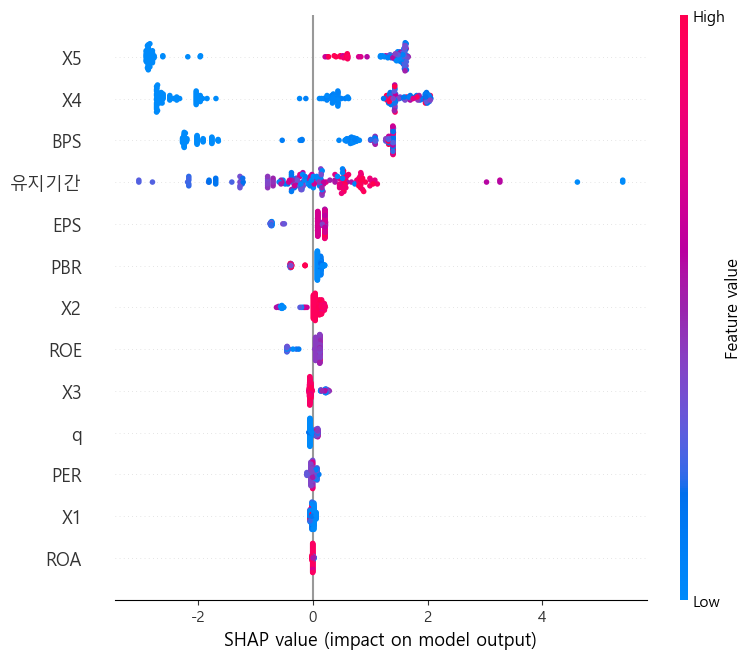

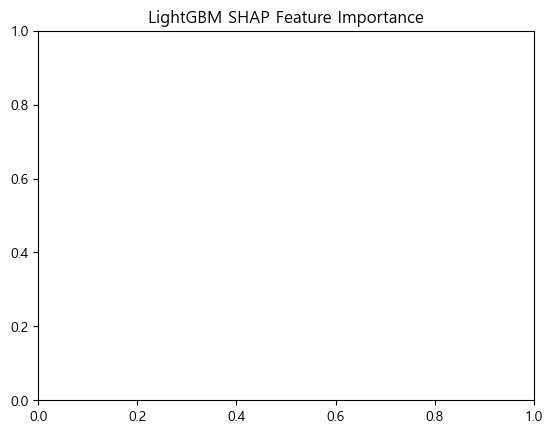

<Figure size 640x480 with 0 Axes>

In [232]:
model_evaluation_ML(df_2023_index)

Random Tree 모델 정확도: 0.91
XGBoost 모델 정확도: 0.91


c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CatBoost 모델 정확도: 0.89
[LightGBM] [Info] Number of positive: 97, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.692857 -> initscore=0.813511
[LightGBM] [Info] Start training from score 0.813511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

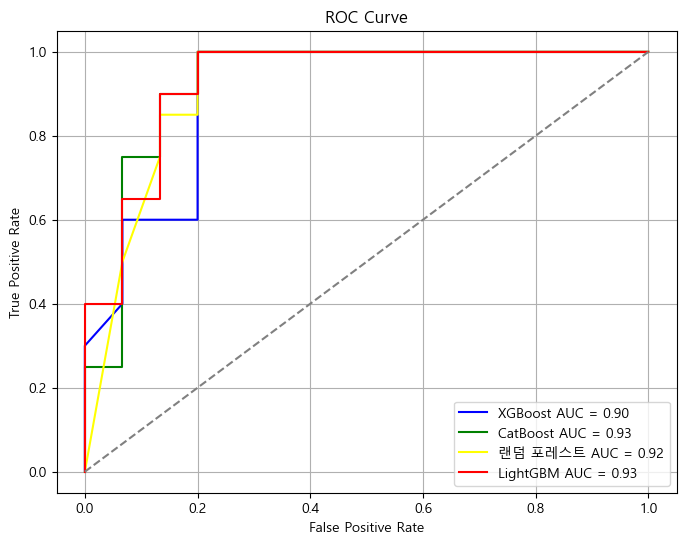

<Figure size 600x400 with 0 Axes>

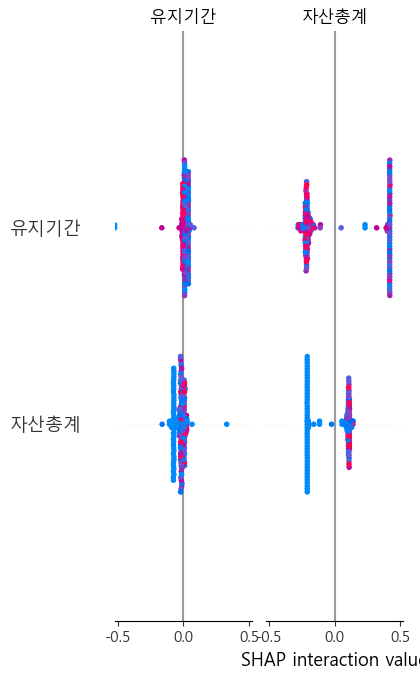

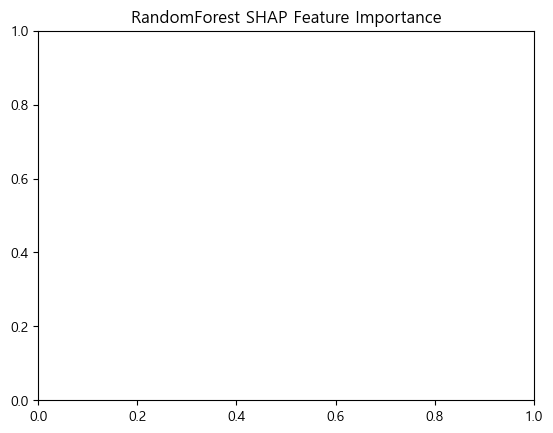

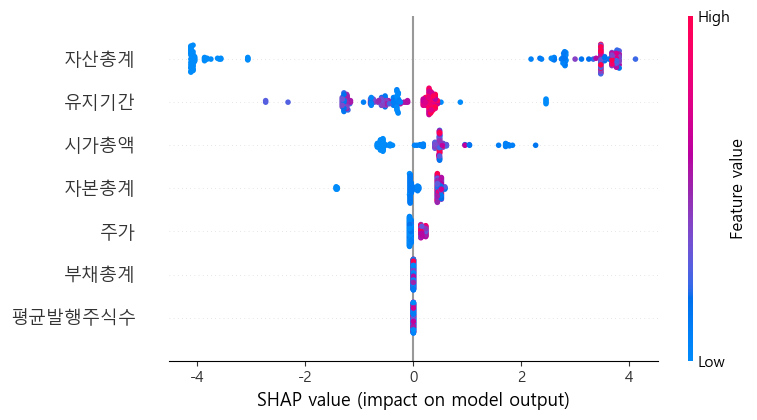

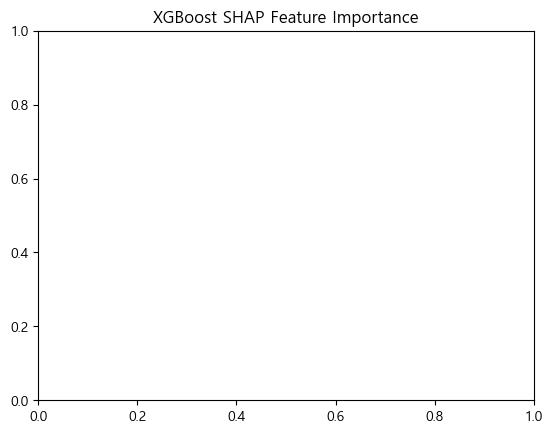

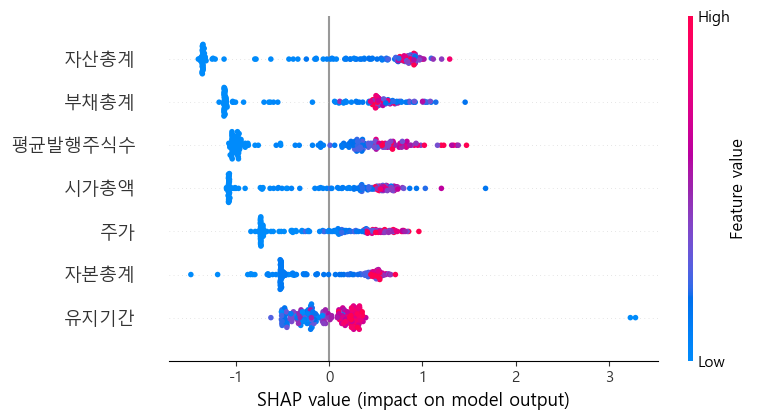

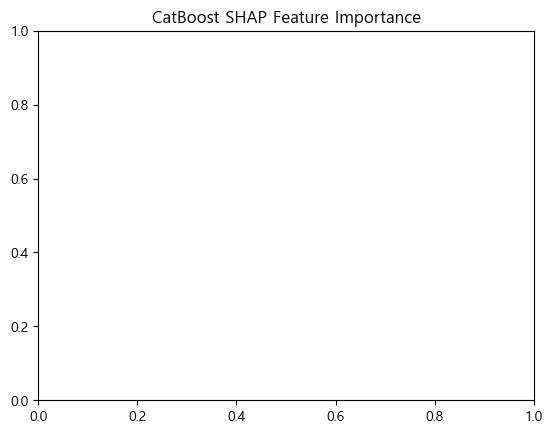

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


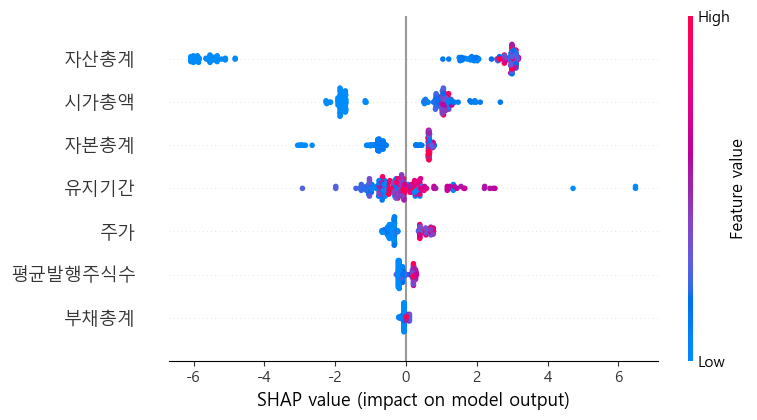

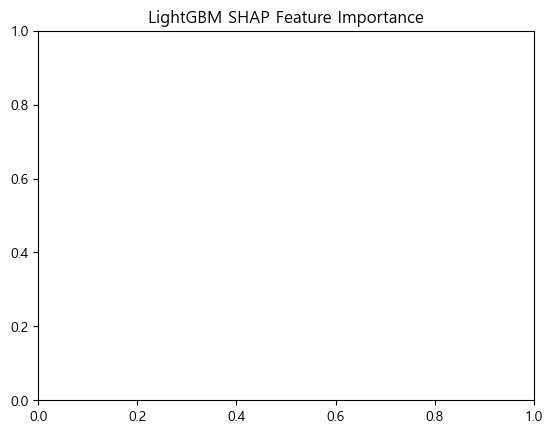

<Figure size 640x480 with 0 Axes>

In [233]:
model_evaluation_ML(df_2023_capital)